In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as ks

In [2]:
from keras.datasets import mnist
(trainX, trainy), (testX, testy) = mnist.load_data()

In [3]:
print(trainX.shape)
print(trainy.shape)

(60000, 28, 28)
(60000,)


In [23]:
img_rows=28
img_cols=28
channel=1
img_shape=(img_rows,img_cols,channel)

In [10]:
from keras.models import Sequential,Model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam

In [12]:
def model_generate():
    noise_shape=(100,)
    model = Sequential()
    model.add(Dense(256,input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape),activation='tanh'))
    model.add(Reshape(img_shape))
    model.summary()
    
    noise = Input(shape=noise_shape)
    fake_img = model(noise)
    
    return Model(noise,fake_img)

In [13]:
def model_discriminate():
    model = Sequential()
    
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1,activation='sigmoid'))
    model.summary()
    
    img = Input(shape=img_shape)
    img_type = model(img)
    
    return Model(img,img_type)

In [19]:
def train(epochs,batch_size=128,save_interval=50):
    (Xtrain,_) ,(_,_) = mnist.load_data()
    Xtrain = (Xtrain.astype(np.float32))/225
    Xtrain = np.expand_dims(Xtrain, axis=3)
    half_batch = batch_size//2
    
    for epoch in range(epochs):
        idx = np.random.randint(0,Xtrain.shape[0],half_batch)
        imgs = Xtrain[idx]
        noise = np.random.normal(0,1,(half_batch,100))
        gen_img = generator.predict(noise)
        
        loss_real = discriminator.train_on_batch(imgs,np.ones((half_batch,1)))
        loss_fake = discriminator.train_on_batch(gen_img,np.zeros((half_batch,1)))
        
        loss = 0.5*np.add(loss_real,loss_fake)
        
        noise = np.random.normal(0,1,(batch_size,100)) 
        
        valid_y = np.array([1]*batch_size)
        
        g_loss = combined.train_on_batch(noise, valid_y)
        # combined is a universal model
        print("%d [D loss: %f, acc. : %.2f%%] [G loss: %f]"%(epoch,loss[0],100*loss[1],g_loss))
        
        if(epoch%save_interval==0):
            save_imgs(epoch)

In [24]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0,1,(r*c,100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5*gen_imgs + 0.5
    
    fig,axis=plt.subplots(r,c)
    cnt=0
    for i in range(r):
        for j in range(c):
            axis[i,j].imshow(gen_imgs[cnt,:,:,0],cmap='gray')
            axis[i,j].axis('off')
            cnt+=1
    fig.savefig('E:\GAN\images\minst_%d.png'%epoch)
    print('saved')
    plt.close()

In [16]:
optimizer = Adam(0.0002, 0.5)
discriminator = model_discriminate()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

generator = model_generate()
generator.compile(loss='binary_crossentropy',
    optimizer=optimizer)

z = Input(shape=(100,))
img = generator(z)

discriminator.trainable = False  

valid = discriminator(img)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

0 [D loss: 0.734203, acc. : 56.25%] [G loss: 0.916125]
saved
1 [D loss: 0.544024, acc. : 93.75%] [G loss: 0.854130]
2 [D loss: 0.506331, acc. : 90.62%] [G loss: 0.811302]
3 [D loss: 0.420154, acc. : 96.88%] [G loss: 0.923697]
4 [D loss: 0.427379, acc. : 93.75%] [G loss: 0.937509]
5 [D loss: 0.351917, acc. : 96.88%] [G loss: 1.067441]
6 [D loss: 0.320814, acc. : 96.88%] [G loss: 1.131990]
7 [D loss: 0.353419, acc. : 90.62%] [G loss: 1.287208]
8 [D loss: 0.222996, acc. : 100.00%] [G loss: 1.419162]
9 [D loss: 0.173130, acc. : 100.00%] [G loss: 1.581507]
10 [D loss: 0.193828, acc. : 100.00%] [G loss: 1.667057]
11 [D loss: 0.186085, acc. : 96.88%] [G loss: 1.766260]
12 [D loss: 0.158208, acc. : 100.00%] [G loss: 1.925046]
13 [D loss: 0.130610, acc. : 100.00%] [G loss: 1.930569]
14 [D loss: 0.143113, acc. : 100.00%] [G loss: 2.157979]
15 [D loss: 0.075788, acc. : 100.00%] [G loss: 2.090575]
16 [D loss: 0.103712, acc. : 100.00%] [G loss: 2.282293]
17 [D loss: 0.072686, acc. : 100.00%] [G los

144 [D loss: 0.249232, acc. : 87.50%] [G loss: 3.202935]
145 [D loss: 0.352879, acc. : 84.38%] [G loss: 2.445983]
146 [D loss: 0.487788, acc. : 75.00%] [G loss: 3.359377]
147 [D loss: 0.179055, acc. : 96.88%] [G loss: 3.486709]
148 [D loss: 0.317103, acc. : 87.50%] [G loss: 2.853773]
149 [D loss: 0.417072, acc. : 87.50%] [G loss: 3.240339]
150 [D loss: 0.366379, acc. : 87.50%] [G loss: 3.857588]
saved
151 [D loss: 0.307107, acc. : 87.50%] [G loss: 3.615845]
152 [D loss: 0.510822, acc. : 81.25%] [G loss: 3.264154]
153 [D loss: 0.322298, acc. : 90.62%] [G loss: 3.748613]
154 [D loss: 0.622402, acc. : 65.62%] [G loss: 3.087699]
155 [D loss: 0.271212, acc. : 93.75%] [G loss: 2.851524]
156 [D loss: 0.245174, acc. : 84.38%] [G loss: 3.205384]
157 [D loss: 0.407958, acc. : 78.12%] [G loss: 3.495840]
158 [D loss: 0.448342, acc. : 78.12%] [G loss: 4.425909]
159 [D loss: 0.425148, acc. : 68.75%] [G loss: 3.957603]
160 [D loss: 0.415975, acc. : 78.12%] [G loss: 3.524027]
161 [D loss: 0.330324, ac

289 [D loss: 0.667242, acc. : 62.50%] [G loss: 3.219329]
290 [D loss: 0.596689, acc. : 62.50%] [G loss: 2.902469]
291 [D loss: 0.476299, acc. : 75.00%] [G loss: 2.673833]
292 [D loss: 0.587591, acc. : 68.75%] [G loss: 3.175125]
293 [D loss: 0.488878, acc. : 71.88%] [G loss: 2.909855]
294 [D loss: 0.403218, acc. : 81.25%] [G loss: 2.732833]
295 [D loss: 0.389999, acc. : 87.50%] [G loss: 2.564783]
296 [D loss: 0.557403, acc. : 71.88%] [G loss: 2.063680]
297 [D loss: 0.548964, acc. : 75.00%] [G loss: 2.420705]
298 [D loss: 0.314242, acc. : 93.75%] [G loss: 2.957221]
299 [D loss: 0.683341, acc. : 53.12%] [G loss: 2.218834]
300 [D loss: 0.559056, acc. : 75.00%] [G loss: 2.519045]
saved
301 [D loss: 0.639529, acc. : 65.62%] [G loss: 2.370805]
302 [D loss: 0.436915, acc. : 81.25%] [G loss: 2.535993]
303 [D loss: 0.545376, acc. : 71.88%] [G loss: 2.288357]
304 [D loss: 0.642002, acc. : 65.62%] [G loss: 2.456197]
305 [D loss: 0.555910, acc. : 68.75%] [G loss: 2.480549]
306 [D loss: 0.577593, ac

433 [D loss: 0.441891, acc. : 81.25%] [G loss: 2.444115]
434 [D loss: 0.493442, acc. : 75.00%] [G loss: 2.249028]
435 [D loss: 0.470942, acc. : 78.12%] [G loss: 2.442241]
436 [D loss: 0.466254, acc. : 71.88%] [G loss: 2.435280]
437 [D loss: 0.412345, acc. : 78.12%] [G loss: 1.762773]
438 [D loss: 0.491186, acc. : 78.12%] [G loss: 2.165517]
439 [D loss: 0.443492, acc. : 81.25%] [G loss: 2.268270]
440 [D loss: 0.525865, acc. : 71.88%] [G loss: 2.004895]
441 [D loss: 0.415053, acc. : 90.62%] [G loss: 2.630832]
442 [D loss: 0.292802, acc. : 90.62%] [G loss: 2.728337]
443 [D loss: 0.505071, acc. : 68.75%] [G loss: 2.505246]
444 [D loss: 0.595245, acc. : 62.50%] [G loss: 2.135747]
445 [D loss: 0.401251, acc. : 90.62%] [G loss: 2.413257]
446 [D loss: 0.475108, acc. : 75.00%] [G loss: 2.362715]
447 [D loss: 0.353515, acc. : 87.50%] [G loss: 2.514195]
448 [D loss: 0.451401, acc. : 78.12%] [G loss: 2.457094]
449 [D loss: 0.404984, acc. : 81.25%] [G loss: 2.243785]
450 [D loss: 0.458327, acc. : 8

577 [D loss: 0.456482, acc. : 87.50%] [G loss: 2.616908]
578 [D loss: 0.486155, acc. : 71.88%] [G loss: 2.555036]
579 [D loss: 0.460458, acc. : 84.38%] [G loss: 2.388039]
580 [D loss: 0.538172, acc. : 75.00%] [G loss: 2.058161]
581 [D loss: 0.428900, acc. : 81.25%] [G loss: 2.225382]
582 [D loss: 0.542584, acc. : 75.00%] [G loss: 2.640514]
583 [D loss: 0.525737, acc. : 78.12%] [G loss: 2.121933]
584 [D loss: 0.429835, acc. : 87.50%] [G loss: 2.205744]
585 [D loss: 0.376507, acc. : 90.62%] [G loss: 2.326369]
586 [D loss: 0.426443, acc. : 84.38%] [G loss: 2.499452]
587 [D loss: 0.451066, acc. : 90.62%] [G loss: 2.004281]
588 [D loss: 0.411796, acc. : 90.62%] [G loss: 2.382170]
589 [D loss: 0.321696, acc. : 93.75%] [G loss: 2.357830]
590 [D loss: 0.555409, acc. : 68.75%] [G loss: 2.411973]
591 [D loss: 0.520144, acc. : 78.12%] [G loss: 2.166735]
592 [D loss: 0.501881, acc. : 81.25%] [G loss: 2.238202]
593 [D loss: 0.368741, acc. : 87.50%] [G loss: 2.352985]
594 [D loss: 0.378510, acc. : 8

721 [D loss: 0.650166, acc. : 59.38%] [G loss: 2.621981]
722 [D loss: 0.424586, acc. : 78.12%] [G loss: 2.390704]
723 [D loss: 0.539843, acc. : 68.75%] [G loss: 2.419924]
724 [D loss: 0.367204, acc. : 87.50%] [G loss: 2.553820]
725 [D loss: 0.569310, acc. : 71.88%] [G loss: 2.356942]
726 [D loss: 0.380600, acc. : 90.62%] [G loss: 2.630424]
727 [D loss: 0.490886, acc. : 84.38%] [G loss: 2.692824]
728 [D loss: 0.591677, acc. : 71.88%] [G loss: 2.490619]
729 [D loss: 0.641465, acc. : 68.75%] [G loss: 2.186235]
730 [D loss: 0.413272, acc. : 84.38%] [G loss: 2.608074]
731 [D loss: 0.268152, acc. : 93.75%] [G loss: 2.798836]
732 [D loss: 0.655642, acc. : 59.38%] [G loss: 1.874604]
733 [D loss: 0.459581, acc. : 81.25%] [G loss: 2.058612]
734 [D loss: 0.471748, acc. : 75.00%] [G loss: 2.798029]
735 [D loss: 0.443872, acc. : 81.25%] [G loss: 2.284979]
736 [D loss: 0.521781, acc. : 71.88%] [G loss: 2.450444]
737 [D loss: 0.562054, acc. : 78.12%] [G loss: 2.324764]
738 [D loss: 0.471901, acc. : 8

864 [D loss: 0.284603, acc. : 93.75%] [G loss: 2.308085]
865 [D loss: 0.550559, acc. : 65.62%] [G loss: 2.462278]
866 [D loss: 0.511456, acc. : 78.12%] [G loss: 2.455778]
867 [D loss: 0.466001, acc. : 81.25%] [G loss: 1.932289]
868 [D loss: 0.544108, acc. : 78.12%] [G loss: 2.653130]
869 [D loss: 0.489722, acc. : 71.88%] [G loss: 2.731819]
870 [D loss: 0.378293, acc. : 84.38%] [G loss: 2.800832]
871 [D loss: 0.395384, acc. : 81.25%] [G loss: 2.719964]
872 [D loss: 0.353037, acc. : 90.62%] [G loss: 3.372021]
873 [D loss: 0.445032, acc. : 75.00%] [G loss: 2.912647]
874 [D loss: 0.470104, acc. : 84.38%] [G loss: 2.797219]
875 [D loss: 0.655174, acc. : 56.25%] [G loss: 2.486140]
876 [D loss: 0.509598, acc. : 71.88%] [G loss: 2.776287]
877 [D loss: 0.369672, acc. : 87.50%] [G loss: 3.411403]
878 [D loss: 0.515003, acc. : 81.25%] [G loss: 2.648546]
879 [D loss: 0.540884, acc. : 65.62%] [G loss: 2.927062]
880 [D loss: 0.501997, acc. : 75.00%] [G loss: 2.174026]
881 [D loss: 0.488989, acc. : 8

1007 [D loss: 0.502644, acc. : 71.88%] [G loss: 3.001164]
1008 [D loss: 0.423677, acc. : 87.50%] [G loss: 2.299969]
1009 [D loss: 0.414450, acc. : 90.62%] [G loss: 1.930217]
1010 [D loss: 0.511898, acc. : 78.12%] [G loss: 2.715418]
1011 [D loss: 0.417992, acc. : 84.38%] [G loss: 2.632220]
1012 [D loss: 0.484559, acc. : 71.88%] [G loss: 2.795765]
1013 [D loss: 0.456089, acc. : 75.00%] [G loss: 2.627056]
1014 [D loss: 0.432313, acc. : 81.25%] [G loss: 3.069643]
1015 [D loss: 0.357137, acc. : 90.62%] [G loss: 2.495111]
1016 [D loss: 0.443858, acc. : 78.12%] [G loss: 2.230206]
1017 [D loss: 0.442916, acc. : 75.00%] [G loss: 2.222692]
1018 [D loss: 0.369120, acc. : 84.38%] [G loss: 3.261010]
1019 [D loss: 0.454999, acc. : 75.00%] [G loss: 3.090277]
1020 [D loss: 0.469813, acc. : 81.25%] [G loss: 2.715409]
1021 [D loss: 0.618092, acc. : 62.50%] [G loss: 3.362232]
1022 [D loss: 0.361030, acc. : 87.50%] [G loss: 2.896798]
1023 [D loss: 0.686558, acc. : 50.00%] [G loss: 2.223857]
1024 [D loss: 

1149 [D loss: 0.352735, acc. : 90.62%] [G loss: 2.225479]
1150 [D loss: 0.693473, acc. : 59.38%] [G loss: 2.126258]
saved
1151 [D loss: 0.513015, acc. : 75.00%] [G loss: 2.531558]
1152 [D loss: 0.442498, acc. : 75.00%] [G loss: 2.551972]
1153 [D loss: 0.358247, acc. : 93.75%] [G loss: 3.140922]
1154 [D loss: 0.316049, acc. : 100.00%] [G loss: 2.428421]
1155 [D loss: 0.590126, acc. : 65.62%] [G loss: 1.274029]
1156 [D loss: 0.722394, acc. : 59.38%] [G loss: 2.535803]
1157 [D loss: 0.571335, acc. : 68.75%] [G loss: 3.175164]
1158 [D loss: 0.375299, acc. : 84.38%] [G loss: 1.948854]
1159 [D loss: 0.599010, acc. : 75.00%] [G loss: 1.413976]
1160 [D loss: 0.654701, acc. : 62.50%] [G loss: 2.173435]
1161 [D loss: 0.486504, acc. : 71.88%] [G loss: 2.018062]
1162 [D loss: 0.421632, acc. : 84.38%] [G loss: 2.414302]
1163 [D loss: 0.386138, acc. : 90.62%] [G loss: 2.938505]
1164 [D loss: 0.504404, acc. : 71.88%] [G loss: 2.589457]
1165 [D loss: 0.494648, acc. : 78.12%] [G loss: 2.014003]
1166 [D

1289 [D loss: 0.287827, acc. : 96.88%] [G loss: 3.146324]
1290 [D loss: 0.539823, acc. : 71.88%] [G loss: 2.005878]
1291 [D loss: 0.666851, acc. : 62.50%] [G loss: 1.288541]
1292 [D loss: 0.746378, acc. : 46.88%] [G loss: 2.273469]
1293 [D loss: 0.669229, acc. : 62.50%] [G loss: 2.839799]
1294 [D loss: 0.558590, acc. : 59.38%] [G loss: 3.112911]
1295 [D loss: 0.357756, acc. : 90.62%] [G loss: 2.385865]
1296 [D loss: 0.468652, acc. : 68.75%] [G loss: 2.264220]
1297 [D loss: 0.535963, acc. : 75.00%] [G loss: 1.716523]
1298 [D loss: 0.655040, acc. : 68.75%] [G loss: 1.222456]
1299 [D loss: 0.576304, acc. : 62.50%] [G loss: 1.715294]
1300 [D loss: 0.488225, acc. : 71.88%] [G loss: 2.216845]
saved
1301 [D loss: 0.358818, acc. : 84.38%] [G loss: 2.385725]
1302 [D loss: 0.343549, acc. : 90.62%] [G loss: 2.221551]
1303 [D loss: 0.319538, acc. : 96.88%] [G loss: 2.478994]
1304 [D loss: 0.440790, acc. : 87.50%] [G loss: 2.309544]
1305 [D loss: 0.556329, acc. : 68.75%] [G loss: 1.939015]
1306 [D 

1430 [D loss: 0.601710, acc. : 59.38%] [G loss: 1.557626]
1431 [D loss: 0.662121, acc. : 59.38%] [G loss: 2.150170]
1432 [D loss: 0.388689, acc. : 87.50%] [G loss: 2.589380]
1433 [D loss: 0.779720, acc. : 34.38%] [G loss: 2.080517]
1434 [D loss: 0.682199, acc. : 62.50%] [G loss: 2.066724]
1435 [D loss: 0.368924, acc. : 87.50%] [G loss: 1.968328]
1436 [D loss: 0.345870, acc. : 87.50%] [G loss: 2.480237]
1437 [D loss: 0.269993, acc. : 90.62%] [G loss: 2.564817]
1438 [D loss: 0.383886, acc. : 87.50%] [G loss: 2.423259]
1439 [D loss: 0.442951, acc. : 75.00%] [G loss: 1.805673]
1440 [D loss: 0.401297, acc. : 90.62%] [G loss: 2.387080]
1441 [D loss: 0.328581, acc. : 90.62%] [G loss: 2.182861]
1442 [D loss: 0.529728, acc. : 65.62%] [G loss: 1.837831]
1443 [D loss: 0.604198, acc. : 65.62%] [G loss: 1.879871]
1444 [D loss: 0.551464, acc. : 68.75%] [G loss: 2.047219]
1445 [D loss: 0.322340, acc. : 93.75%] [G loss: 2.689878]
1446 [D loss: 0.312462, acc. : 96.88%] [G loss: 3.275437]
1447 [D loss: 

1570 [D loss: 0.462074, acc. : 84.38%] [G loss: 1.939760]
1571 [D loss: 0.453195, acc. : 78.12%] [G loss: 2.162233]
1572 [D loss: 0.451502, acc. : 75.00%] [G loss: 3.253686]
1573 [D loss: 0.309805, acc. : 87.50%] [G loss: 3.370802]
1574 [D loss: 0.548814, acc. : 62.50%] [G loss: 1.567094]
1575 [D loss: 0.354495, acc. : 87.50%] [G loss: 2.330534]
1576 [D loss: 0.635925, acc. : 68.75%] [G loss: 2.447853]
1577 [D loss: 0.338541, acc. : 78.12%] [G loss: 5.253298]
1578 [D loss: 0.325952, acc. : 81.25%] [G loss: 5.607493]
1579 [D loss: 0.406196, acc. : 84.38%] [G loss: 2.602896]
1580 [D loss: 0.184840, acc. : 96.88%] [G loss: 10.598941]
1581 [D loss: 0.538968, acc. : 75.00%] [G loss: 2.331180]
1582 [D loss: 0.283484, acc. : 93.75%] [G loss: 5.671025]
1583 [D loss: 0.397157, acc. : 87.50%] [G loss: 2.201766]
1584 [D loss: 0.455090, acc. : 84.38%] [G loss: 2.048518]
1585 [D loss: 0.498267, acc. : 68.75%] [G loss: 2.093338]
1586 [D loss: 0.471342, acc. : 75.00%] [G loss: 2.004008]
1587 [D loss:

1711 [D loss: 0.291065, acc. : 90.62%] [G loss: 3.053164]
1712 [D loss: 0.345611, acc. : 81.25%] [G loss: 3.611150]
1713 [D loss: 0.356543, acc. : 84.38%] [G loss: 3.958016]
1714 [D loss: 0.322886, acc. : 87.50%] [G loss: 2.894883]
1715 [D loss: 0.207684, acc. : 96.88%] [G loss: 2.937822]
1716 [D loss: 0.172962, acc. : 96.88%] [G loss: 5.295473]
1717 [D loss: 0.162906, acc. : 96.88%] [G loss: 4.318868]
1718 [D loss: 0.535144, acc. : 68.75%] [G loss: 2.639095]
1719 [D loss: 0.256155, acc. : 93.75%] [G loss: 2.797631]
1720 [D loss: 0.300780, acc. : 93.75%] [G loss: 3.077970]
1721 [D loss: 0.499391, acc. : 75.00%] [G loss: 2.511207]
1722 [D loss: 0.380499, acc. : 78.12%] [G loss: 3.115442]
1723 [D loss: 0.536385, acc. : 65.62%] [G loss: 2.009804]
1724 [D loss: 0.350336, acc. : 81.25%] [G loss: 3.198343]
1725 [D loss: 0.656345, acc. : 53.12%] [G loss: 2.046181]
1726 [D loss: 0.378661, acc. : 84.38%] [G loss: 4.726424]
1727 [D loss: 0.622773, acc. : 68.75%] [G loss: 1.530354]
1728 [D loss: 

1852 [D loss: 0.326736, acc. : 81.25%] [G loss: 5.337219]
1853 [D loss: 0.221180, acc. : 96.88%] [G loss: 5.105580]
1854 [D loss: 0.183911, acc. : 96.88%] [G loss: 5.710303]
1855 [D loss: 0.365366, acc. : 81.25%] [G loss: 2.078489]
1856 [D loss: 0.150854, acc. : 100.00%] [G loss: 6.515039]
1857 [D loss: 0.431214, acc. : 78.12%] [G loss: 6.780229]
1858 [D loss: 0.170714, acc. : 96.88%] [G loss: 4.289291]
1859 [D loss: 0.365427, acc. : 81.25%] [G loss: 2.252822]
1860 [D loss: 0.328351, acc. : 90.62%] [G loss: 5.001656]
1861 [D loss: 0.591875, acc. : 81.25%] [G loss: 3.689124]
1862 [D loss: 0.153348, acc. : 100.00%] [G loss: 4.863096]
1863 [D loss: 0.326317, acc. : 87.50%] [G loss: 4.233468]
1864 [D loss: 0.588320, acc. : 68.75%] [G loss: 3.029272]
1865 [D loss: 0.269100, acc. : 96.88%] [G loss: 2.697482]
1866 [D loss: 0.305136, acc. : 87.50%] [G loss: 4.665749]
1867 [D loss: 0.270475, acc. : 93.75%] [G loss: 3.873688]
1868 [D loss: 0.139006, acc. : 100.00%] [G loss: 4.557952]
1869 [D los

1994 [D loss: 0.150151, acc. : 93.75%] [G loss: 5.955251]
1995 [D loss: 0.177142, acc. : 90.62%] [G loss: 6.857917]
1996 [D loss: 0.333698, acc. : 84.38%] [G loss: 4.658092]
1997 [D loss: 0.141558, acc. : 100.00%] [G loss: 5.806321]
1998 [D loss: 0.307462, acc. : 90.62%] [G loss: 2.666662]
1999 [D loss: 0.396259, acc. : 81.25%] [G loss: 2.535204]
2000 [D loss: 0.211043, acc. : 93.75%] [G loss: 2.623262]
saved
2001 [D loss: 0.728219, acc. : 43.75%] [G loss: 1.243384]
2002 [D loss: 0.382162, acc. : 87.50%] [G loss: 2.499356]
2003 [D loss: 0.455806, acc. : 75.00%] [G loss: 3.075634]
2004 [D loss: 0.195208, acc. : 90.62%] [G loss: 2.488524]
2005 [D loss: 0.628363, acc. : 65.62%] [G loss: 1.576769]
2006 [D loss: 0.294147, acc. : 93.75%] [G loss: 2.902035]
2007 [D loss: 0.242275, acc. : 84.38%] [G loss: 4.329038]
2008 [D loss: 0.364443, acc. : 78.12%] [G loss: 3.890815]
2009 [D loss: 0.231782, acc. : 90.62%] [G loss: 3.223167]
2010 [D loss: 0.662406, acc. : 59.38%] [G loss: 2.478597]
2011 [D

2136 [D loss: 0.411147, acc. : 84.38%] [G loss: 2.351833]
2137 [D loss: 0.657241, acc. : 65.62%] [G loss: 3.422107]
2138 [D loss: 0.371484, acc. : 87.50%] [G loss: 4.755920]
2139 [D loss: 0.165342, acc. : 96.88%] [G loss: 8.014284]
2140 [D loss: 0.286177, acc. : 87.50%] [G loss: 3.720671]
2141 [D loss: 0.237983, acc. : 93.75%] [G loss: 3.376867]
2142 [D loss: 0.636917, acc. : 59.38%] [G loss: 1.430683]
2143 [D loss: 0.387783, acc. : 81.25%] [G loss: 3.248533]
2144 [D loss: 0.355413, acc. : 84.38%] [G loss: 3.679273]
2145 [D loss: 0.536702, acc. : 62.50%] [G loss: 2.756359]
2146 [D loss: 0.318097, acc. : 87.50%] [G loss: 4.819561]
2147 [D loss: 0.227764, acc. : 96.88%] [G loss: 9.605228]
2148 [D loss: 0.592358, acc. : 62.50%] [G loss: 1.245432]
2149 [D loss: 0.375399, acc. : 84.38%] [G loss: 3.557487]
2150 [D loss: 0.372986, acc. : 78.12%] [G loss: 6.267575]
saved
2151 [D loss: 0.267516, acc. : 90.62%] [G loss: 4.478798]
2152 [D loss: 0.629327, acc. : 68.75%] [G loss: 1.894271]
2153 [D 

2278 [D loss: 0.234795, acc. : 93.75%] [G loss: 4.831977]
2279 [D loss: 0.109813, acc. : 100.00%] [G loss: 9.154934]
2280 [D loss: 0.468024, acc. : 75.00%] [G loss: 2.682353]
2281 [D loss: 0.155992, acc. : 100.00%] [G loss: 2.059884]
2282 [D loss: 0.411083, acc. : 81.25%] [G loss: 6.760067]
2283 [D loss: 0.125624, acc. : 100.00%] [G loss: 7.721306]
2284 [D loss: 0.465831, acc. : 71.88%] [G loss: 2.752467]
2285 [D loss: 0.401743, acc. : 87.50%] [G loss: 1.263277]
2286 [D loss: 0.493464, acc. : 65.62%] [G loss: 2.211410]
2287 [D loss: 0.340503, acc. : 78.12%] [G loss: 3.983492]
2288 [D loss: 0.349230, acc. : 93.75%] [G loss: 2.016331]
2289 [D loss: 0.590710, acc. : 65.62%] [G loss: 1.517764]
2290 [D loss: 0.436089, acc. : 81.25%] [G loss: 2.179453]
2291 [D loss: 0.416616, acc. : 81.25%] [G loss: 2.142742]
2292 [D loss: 0.458767, acc. : 81.25%] [G loss: 2.009786]
2293 [D loss: 0.479867, acc. : 65.62%] [G loss: 1.975341]
2294 [D loss: 0.237047, acc. : 96.88%] [G loss: 5.675109]
2295 [D los

2419 [D loss: 0.203798, acc. : 93.75%] [G loss: 6.550201]
2420 [D loss: 0.551018, acc. : 65.62%] [G loss: 3.106551]
2421 [D loss: 0.172192, acc. : 96.88%] [G loss: 6.456214]
2422 [D loss: 0.165053, acc. : 93.75%] [G loss: 5.231150]
2423 [D loss: 0.412564, acc. : 78.12%] [G loss: 3.518872]
2424 [D loss: 0.172394, acc. : 96.88%] [G loss: 5.680285]
2425 [D loss: 0.290480, acc. : 90.62%] [G loss: 5.924375]
2426 [D loss: 0.215214, acc. : 93.75%] [G loss: 4.840272]
2427 [D loss: 0.244932, acc. : 93.75%] [G loss: 3.211008]
2428 [D loss: 0.228539, acc. : 96.88%] [G loss: 3.192404]
2429 [D loss: 0.277049, acc. : 93.75%] [G loss: 2.992988]
2430 [D loss: 0.243780, acc. : 93.75%] [G loss: 4.011105]
2431 [D loss: 0.368577, acc. : 87.50%] [G loss: 3.077905]
2432 [D loss: 0.556389, acc. : 75.00%] [G loss: 3.499643]
2433 [D loss: 0.505843, acc. : 84.38%] [G loss: 5.826638]
2434 [D loss: 0.240507, acc. : 93.75%] [G loss: 6.128081]
2435 [D loss: 0.587102, acc. : 65.62%] [G loss: 2.501475]
2436 [D loss: 

2559 [D loss: 0.215769, acc. : 96.88%] [G loss: 2.627953]
2560 [D loss: 0.393048, acc. : 81.25%] [G loss: 2.582831]
2561 [D loss: 0.250836, acc. : 93.75%] [G loss: 5.919404]
2562 [D loss: 0.282649, acc. : 87.50%] [G loss: 7.037273]
2563 [D loss: 0.301647, acc. : 87.50%] [G loss: 2.457361]
2564 [D loss: 0.541050, acc. : 65.62%] [G loss: 2.419122]
2565 [D loss: 0.353767, acc. : 81.25%] [G loss: 4.015469]
2566 [D loss: 0.349730, acc. : 84.38%] [G loss: 5.599142]
2567 [D loss: 0.340006, acc. : 87.50%] [G loss: 3.901860]
2568 [D loss: 0.217908, acc. : 90.62%] [G loss: 4.399737]
2569 [D loss: 0.371380, acc. : 75.00%] [G loss: 4.228021]
2570 [D loss: 0.461923, acc. : 71.88%] [G loss: 2.027319]
2571 [D loss: 0.372927, acc. : 81.25%] [G loss: 2.194996]
2572 [D loss: 0.272972, acc. : 90.62%] [G loss: 2.933750]
2573 [D loss: 0.309812, acc. : 90.62%] [G loss: 3.671292]
2574 [D loss: 0.148283, acc. : 100.00%] [G loss: 3.867474]
2575 [D loss: 0.226402, acc. : 90.62%] [G loss: 3.255592]
2576 [D loss:

2699 [D loss: 0.345640, acc. : 84.38%] [G loss: 4.335976]
2700 [D loss: 0.166353, acc. : 96.88%] [G loss: 7.510405]
saved
2701 [D loss: 0.155387, acc. : 93.75%] [G loss: 5.228347]
2702 [D loss: 0.327183, acc. : 81.25%] [G loss: 2.947001]
2703 [D loss: 0.407068, acc. : 87.50%] [G loss: 2.127975]
2704 [D loss: 0.389752, acc. : 81.25%] [G loss: 3.276845]
2705 [D loss: 0.429977, acc. : 78.12%] [G loss: 2.898539]
2706 [D loss: 0.420378, acc. : 84.38%] [G loss: 3.670216]
2707 [D loss: 0.268815, acc. : 93.75%] [G loss: 5.402539]
2708 [D loss: 0.271571, acc. : 93.75%] [G loss: 3.836974]
2709 [D loss: 0.581766, acc. : 65.62%] [G loss: 6.622113]
2710 [D loss: 0.175373, acc. : 93.75%] [G loss: 6.431936]
2711 [D loss: 0.378714, acc. : 81.25%] [G loss: 4.850956]
2712 [D loss: 0.128264, acc. : 96.88%] [G loss: 2.526852]
2713 [D loss: 0.705158, acc. : 59.38%] [G loss: 2.396182]
2714 [D loss: 0.530735, acc. : 68.75%] [G loss: 2.655446]
2715 [D loss: 0.501116, acc. : 78.12%] [G loss: 3.490048]
2716 [D 

2840 [D loss: 0.354743, acc. : 78.12%] [G loss: 3.628506]
2841 [D loss: 0.203284, acc. : 96.88%] [G loss: 3.784963]
2842 [D loss: 0.395451, acc. : 81.25%] [G loss: 2.379734]
2843 [D loss: 0.475205, acc. : 75.00%] [G loss: 2.427733]
2844 [D loss: 0.363752, acc. : 78.12%] [G loss: 4.805175]
2845 [D loss: 0.308980, acc. : 87.50%] [G loss: 3.353433]
2846 [D loss: 0.245246, acc. : 96.88%] [G loss: 2.067971]
2847 [D loss: 0.499613, acc. : 68.75%] [G loss: 1.644546]
2848 [D loss: 0.208445, acc. : 93.75%] [G loss: 4.812218]
2849 [D loss: 0.236105, acc. : 100.00%] [G loss: 5.243159]
2850 [D loss: 0.258152, acc. : 96.88%] [G loss: 6.109303]
saved
2851 [D loss: 0.428962, acc. : 81.25%] [G loss: 2.561857]
2852 [D loss: 0.265731, acc. : 93.75%] [G loss: 1.663404]
2853 [D loss: 0.544556, acc. : 62.50%] [G loss: 2.465629]
2854 [D loss: 0.530994, acc. : 68.75%] [G loss: 2.670390]
2855 [D loss: 0.262535, acc. : 90.62%] [G loss: 5.605706]
2856 [D loss: 0.199640, acc. : 90.62%] [G loss: 6.627410]
2857 [D

2981 [D loss: 0.196095, acc. : 100.00%] [G loss: 7.021039]
2982 [D loss: 0.135559, acc. : 100.00%] [G loss: 4.168829]
2983 [D loss: 0.412471, acc. : 84.38%] [G loss: 3.038175]
2984 [D loss: 0.195791, acc. : 96.88%] [G loss: 3.837943]
2985 [D loss: 0.595418, acc. : 59.38%] [G loss: 2.468575]
2986 [D loss: 0.344038, acc. : 90.62%] [G loss: 2.321760]
2987 [D loss: 0.426079, acc. : 84.38%] [G loss: 3.933722]
2988 [D loss: 0.395525, acc. : 84.38%] [G loss: 3.167809]
2989 [D loss: 0.294706, acc. : 87.50%] [G loss: 3.879941]
2990 [D loss: 0.280903, acc. : 93.75%] [G loss: 6.839649]
2991 [D loss: 0.188811, acc. : 96.88%] [G loss: 5.339666]
2992 [D loss: 0.257097, acc. : 90.62%] [G loss: 3.491140]
2993 [D loss: 0.147700, acc. : 96.88%] [G loss: 3.162247]
2994 [D loss: 0.239580, acc. : 93.75%] [G loss: 4.492496]
2995 [D loss: 0.172453, acc. : 96.88%] [G loss: 7.585280]
2996 [D loss: 0.346368, acc. : 84.38%] [G loss: 3.625925]
2997 [D loss: 0.134836, acc. : 96.88%] [G loss: 6.295295]
2998 [D loss

3122 [D loss: 0.521568, acc. : 68.75%] [G loss: 3.344810]
3123 [D loss: 0.411840, acc. : 84.38%] [G loss: 2.443483]
3124 [D loss: 0.347971, acc. : 84.38%] [G loss: 3.601127]
3125 [D loss: 0.310309, acc. : 84.38%] [G loss: 5.317777]
3126 [D loss: 0.510178, acc. : 71.88%] [G loss: 1.760765]
3127 [D loss: 0.290512, acc. : 90.62%] [G loss: 3.095492]
3128 [D loss: 0.375357, acc. : 93.75%] [G loss: 3.406311]
3129 [D loss: 0.448446, acc. : 78.12%] [G loss: 1.903996]
3130 [D loss: 0.604578, acc. : 62.50%] [G loss: 1.230490]
3131 [D loss: 0.426311, acc. : 84.38%] [G loss: 3.121386]
3132 [D loss: 0.460781, acc. : 84.38%] [G loss: 2.799079]
3133 [D loss: 0.391184, acc. : 81.25%] [G loss: 3.854364]
3134 [D loss: 0.465538, acc. : 71.88%] [G loss: 1.393432]
3135 [D loss: 0.209674, acc. : 96.88%] [G loss: 5.474760]
3136 [D loss: 0.259460, acc. : 90.62%] [G loss: 5.533069]
3137 [D loss: 0.482279, acc. : 71.88%] [G loss: 2.036800]
3138 [D loss: 0.529172, acc. : 62.50%] [G loss: 2.373654]
3139 [D loss: 

3263 [D loss: 0.337136, acc. : 93.75%] [G loss: 2.235059]
3264 [D loss: 0.404289, acc. : 84.38%] [G loss: 4.858032]
3265 [D loss: 0.409887, acc. : 87.50%] [G loss: 3.607271]
3266 [D loss: 0.543689, acc. : 65.62%] [G loss: 3.431048]
3267 [D loss: 0.652791, acc. : 59.38%] [G loss: 3.044450]
3268 [D loss: 0.471371, acc. : 65.62%] [G loss: 3.441478]
3269 [D loss: 0.291894, acc. : 90.62%] [G loss: 2.804630]
3270 [D loss: 0.548498, acc. : 78.12%] [G loss: 2.435348]
3271 [D loss: 0.387921, acc. : 84.38%] [G loss: 5.342038]
3272 [D loss: 0.300896, acc. : 96.88%] [G loss: 3.911563]
3273 [D loss: 0.391251, acc. : 81.25%] [G loss: 5.324285]
3274 [D loss: 0.585519, acc. : 65.62%] [G loss: 3.468626]
3275 [D loss: 0.442794, acc. : 84.38%] [G loss: 2.902073]
3276 [D loss: 0.619417, acc. : 53.12%] [G loss: 3.272875]
3277 [D loss: 0.281372, acc. : 96.88%] [G loss: 3.808107]
3278 [D loss: 0.224403, acc. : 93.75%] [G loss: 3.849023]
3279 [D loss: 0.341268, acc. : 81.25%] [G loss: 4.198754]
3280 [D loss: 

3404 [D loss: 0.514947, acc. : 75.00%] [G loss: 3.931005]
3405 [D loss: 0.371987, acc. : 84.38%] [G loss: 2.734415]
3406 [D loss: 0.547067, acc. : 65.62%] [G loss: 2.399698]
3407 [D loss: 0.193432, acc. : 100.00%] [G loss: 4.233719]
3408 [D loss: 0.409658, acc. : 84.38%] [G loss: 4.772298]
3409 [D loss: 0.298042, acc. : 87.50%] [G loss: 4.910386]
3410 [D loss: 0.413225, acc. : 78.12%] [G loss: 4.514487]
3411 [D loss: 0.252750, acc. : 93.75%] [G loss: 10.216976]
3412 [D loss: 0.406973, acc. : 78.12%] [G loss: 3.148306]
3413 [D loss: 0.149315, acc. : 96.88%] [G loss: 5.811233]
3414 [D loss: 0.529331, acc. : 68.75%] [G loss: 2.061717]
3415 [D loss: 0.255535, acc. : 96.88%] [G loss: 3.506909]
3416 [D loss: 0.625862, acc. : 65.62%] [G loss: 3.519744]
3417 [D loss: 0.193205, acc. : 96.88%] [G loss: 6.861982]
3418 [D loss: 0.516749, acc. : 65.62%] [G loss: 4.028059]
3419 [D loss: 0.269940, acc. : 87.50%] [G loss: 6.506975]
3420 [D loss: 0.188346, acc. : 93.75%] [G loss: 4.543231]
3421 [D loss

3545 [D loss: 0.367244, acc. : 84.38%] [G loss: 4.470516]
3546 [D loss: 0.320529, acc. : 87.50%] [G loss: 5.059172]
3547 [D loss: 0.374824, acc. : 84.38%] [G loss: 2.973202]
3548 [D loss: 0.349517, acc. : 90.62%] [G loss: 3.535729]
3549 [D loss: 0.498594, acc. : 68.75%] [G loss: 2.881998]
3550 [D loss: 0.529559, acc. : 68.75%] [G loss: 3.817338]
saved
3551 [D loss: 0.534245, acc. : 71.88%] [G loss: 2.939456]
3552 [D loss: 0.465349, acc. : 68.75%] [G loss: 5.217279]
3553 [D loss: 0.328357, acc. : 90.62%] [G loss: 7.176836]
3554 [D loss: 0.570132, acc. : 62.50%] [G loss: 3.816666]
3555 [D loss: 0.180412, acc. : 96.88%] [G loss: 3.672141]
3556 [D loss: 0.436341, acc. : 84.38%] [G loss: 3.784508]
3557 [D loss: 0.394046, acc. : 81.25%] [G loss: 7.112285]
3558 [D loss: 0.492926, acc. : 81.25%] [G loss: 3.808418]
3559 [D loss: 0.475439, acc. : 71.88%] [G loss: 3.478633]
3560 [D loss: 0.179029, acc. : 93.75%] [G loss: 5.664391]
3561 [D loss: 0.261707, acc. : 90.62%] [G loss: 8.868683]
3562 [D 

3686 [D loss: 0.479178, acc. : 68.75%] [G loss: 3.301732]
3687 [D loss: 0.324525, acc. : 90.62%] [G loss: 4.929790]
3688 [D loss: 0.587404, acc. : 68.75%] [G loss: 3.498805]
3689 [D loss: 0.535760, acc. : 65.62%] [G loss: 2.026620]
3690 [D loss: 0.427424, acc. : 71.88%] [G loss: 2.565331]
3691 [D loss: 0.569224, acc. : 68.75%] [G loss: 1.891830]
3692 [D loss: 0.363359, acc. : 90.62%] [G loss: 6.196547]
3693 [D loss: 0.260552, acc. : 93.75%] [G loss: 3.947909]
3694 [D loss: 0.293964, acc. : 93.75%] [G loss: 6.176859]
3695 [D loss: 0.292130, acc. : 81.25%] [G loss: 6.203896]
3696 [D loss: 0.161139, acc. : 96.88%] [G loss: 7.474801]
3697 [D loss: 0.332795, acc. : 87.50%] [G loss: 6.940754]
3698 [D loss: 0.412335, acc. : 68.75%] [G loss: 2.291174]
3699 [D loss: 0.299962, acc. : 90.62%] [G loss: 2.547291]
3700 [D loss: 0.710986, acc. : 50.00%] [G loss: 1.856694]
saved
3701 [D loss: 0.381189, acc. : 84.38%] [G loss: 2.779201]
3702 [D loss: 0.435942, acc. : 81.25%] [G loss: 3.686892]
3703 [D 

3827 [D loss: 0.290464, acc. : 90.62%] [G loss: 3.310335]
3828 [D loss: 0.335705, acc. : 81.25%] [G loss: 3.189365]
3829 [D loss: 0.321704, acc. : 96.88%] [G loss: 3.858614]
3830 [D loss: 0.327791, acc. : 93.75%] [G loss: 3.710513]
3831 [D loss: 0.508930, acc. : 75.00%] [G loss: 4.273403]
3832 [D loss: 0.421266, acc. : 78.12%] [G loss: 3.799347]
3833 [D loss: 0.354791, acc. : 81.25%] [G loss: 4.561289]
3834 [D loss: 0.383534, acc. : 78.12%] [G loss: 4.397898]
3835 [D loss: 0.363027, acc. : 84.38%] [G loss: 3.076306]
3836 [D loss: 0.367409, acc. : 84.38%] [G loss: 3.447082]
3837 [D loss: 0.462695, acc. : 81.25%] [G loss: 2.876270]
3838 [D loss: 0.425922, acc. : 84.38%] [G loss: 4.151137]
3839 [D loss: 0.289843, acc. : 93.75%] [G loss: 4.594666]
3840 [D loss: 0.393617, acc. : 71.88%] [G loss: 3.663209]
3841 [D loss: 0.278345, acc. : 84.38%] [G loss: 7.626220]
3842 [D loss: 0.252941, acc. : 93.75%] [G loss: 4.605696]
3843 [D loss: 0.170805, acc. : 96.88%] [G loss: 7.854799]
3844 [D loss: 

3968 [D loss: 0.430575, acc. : 75.00%] [G loss: 4.521276]
3969 [D loss: 0.546888, acc. : 90.62%] [G loss: 3.167878]
3970 [D loss: 0.358333, acc. : 90.62%] [G loss: 2.532105]
3971 [D loss: 0.253876, acc. : 96.88%] [G loss: 2.243105]
3972 [D loss: 0.328804, acc. : 84.38%] [G loss: 1.835546]
3973 [D loss: 0.335982, acc. : 84.38%] [G loss: 2.250503]
3974 [D loss: 0.361008, acc. : 81.25%] [G loss: 2.933975]
3975 [D loss: 0.368628, acc. : 84.38%] [G loss: 4.426913]
3976 [D loss: 0.313730, acc. : 84.38%] [G loss: 3.376587]
3977 [D loss: 0.266713, acc. : 93.75%] [G loss: 9.163553]
3978 [D loss: 0.323965, acc. : 84.38%] [G loss: 4.179464]
3979 [D loss: 0.201740, acc. : 90.62%] [G loss: 7.578954]
3980 [D loss: 0.287434, acc. : 84.38%] [G loss: 3.945511]
3981 [D loss: 0.413676, acc. : 78.12%] [G loss: 2.322174]
3982 [D loss: 0.403473, acc. : 75.00%] [G loss: 3.523137]
3983 [D loss: 0.703320, acc. : 81.25%] [G loss: 5.358109]
3984 [D loss: 0.843890, acc. : 53.12%] [G loss: 2.356627]
3985 [D loss: 

4108 [D loss: 0.372311, acc. : 78.12%] [G loss: 3.097964]
4109 [D loss: 0.338461, acc. : 84.38%] [G loss: 3.021008]
4110 [D loss: 0.502037, acc. : 81.25%] [G loss: 3.027954]
4111 [D loss: 0.322992, acc. : 87.50%] [G loss: 4.372713]
4112 [D loss: 0.354050, acc. : 84.38%] [G loss: 3.666209]
4113 [D loss: 0.232015, acc. : 90.62%] [G loss: 6.928184]
4114 [D loss: 0.272770, acc. : 84.38%] [G loss: 5.215037]
4115 [D loss: 0.223515, acc. : 90.62%] [G loss: 3.770402]
4116 [D loss: 0.237246, acc. : 87.50%] [G loss: 5.292358]
4117 [D loss: 0.372615, acc. : 84.38%] [G loss: 5.408907]
4118 [D loss: 0.214173, acc. : 90.62%] [G loss: 7.183356]
4119 [D loss: 0.181283, acc. : 100.00%] [G loss: 6.677485]
4120 [D loss: 0.350206, acc. : 84.38%] [G loss: 6.202633]
4121 [D loss: 0.250221, acc. : 87.50%] [G loss: 3.376051]
4122 [D loss: 0.300714, acc. : 81.25%] [G loss: 3.555414]
4123 [D loss: 0.425009, acc. : 75.00%] [G loss: 2.503716]
4124 [D loss: 0.222414, acc. : 96.88%] [G loss: 4.223749]
4125 [D loss:

4249 [D loss: 0.357793, acc. : 84.38%] [G loss: 6.078733]
4250 [D loss: 0.090833, acc. : 100.00%] [G loss: 9.632913]
saved
4251 [D loss: 0.202471, acc. : 100.00%] [G loss: 4.735042]
4252 [D loss: 0.206382, acc. : 90.62%] [G loss: 6.617476]
4253 [D loss: 0.099289, acc. : 100.00%] [G loss: 3.743825]
4254 [D loss: 0.210904, acc. : 93.75%] [G loss: 3.181057]
4255 [D loss: 0.088892, acc. : 100.00%] [G loss: 9.485367]
4256 [D loss: 0.154915, acc. : 93.75%] [G loss: 8.173630]
4257 [D loss: 0.262720, acc. : 78.12%] [G loss: 3.984126]
4258 [D loss: 0.326760, acc. : 84.38%] [G loss: 2.597389]
4259 [D loss: 0.205881, acc. : 93.75%] [G loss: 2.458700]
4260 [D loss: 0.323441, acc. : 78.12%] [G loss: 3.818777]
4261 [D loss: 0.269805, acc. : 100.00%] [G loss: 8.043928]
4262 [D loss: 0.278356, acc. : 87.50%] [G loss: 3.946853]
4263 [D loss: 0.283794, acc. : 90.62%] [G loss: 2.927376]
4264 [D loss: 0.249485, acc. : 90.62%] [G loss: 3.849186]
4265 [D loss: 0.342881, acc. : 90.62%] [G loss: 3.069203]
426

4391 [D loss: 0.214637, acc. : 93.75%] [G loss: 5.320459]
4392 [D loss: 0.203302, acc. : 90.62%] [G loss: 5.239275]
4393 [D loss: 0.406454, acc. : 71.88%] [G loss: 8.527760]
4394 [D loss: 0.119149, acc. : 96.88%] [G loss: 7.908381]
4395 [D loss: 0.231693, acc. : 93.75%] [G loss: 5.028226]
4396 [D loss: 0.380696, acc. : 78.12%] [G loss: 5.212463]
4397 [D loss: 0.364129, acc. : 90.62%] [G loss: 3.372671]
4398 [D loss: 0.243803, acc. : 90.62%] [G loss: 7.285808]
4399 [D loss: 0.270049, acc. : 90.62%] [G loss: 5.891584]
4400 [D loss: 0.179867, acc. : 93.75%] [G loss: 5.623443]
saved
4401 [D loss: 0.439384, acc. : 68.75%] [G loss: 3.688385]
4402 [D loss: 0.189846, acc. : 93.75%] [G loss: 4.864547]
4403 [D loss: 0.283840, acc. : 96.88%] [G loss: 4.215469]
4404 [D loss: 0.305098, acc. : 96.88%] [G loss: 4.651920]
4405 [D loss: 0.172214, acc. : 100.00%] [G loss: 3.976142]
4406 [D loss: 0.277044, acc. : 90.62%] [G loss: 5.337247]
4407 [D loss: 0.272616, acc. : 90.62%] [G loss: 5.517156]
4408 [D

4532 [D loss: 0.304493, acc. : 93.75%] [G loss: 1.970622]
4533 [D loss: 0.360173, acc. : 87.50%] [G loss: 6.284279]
4534 [D loss: 0.109372, acc. : 100.00%] [G loss: 8.369860]
4535 [D loss: 0.171569, acc. : 96.88%] [G loss: 5.671354]
4536 [D loss: 0.144222, acc. : 100.00%] [G loss: 4.504505]
4537 [D loss: 0.136033, acc. : 93.75%] [G loss: 4.672893]
4538 [D loss: 0.314014, acc. : 87.50%] [G loss: 4.550843]
4539 [D loss: 0.274044, acc. : 90.62%] [G loss: 6.575611]
4540 [D loss: 0.288404, acc. : 87.50%] [G loss: 4.388533]
4541 [D loss: 0.505413, acc. : 81.25%] [G loss: 5.134731]
4542 [D loss: 0.266382, acc. : 90.62%] [G loss: 6.149140]
4543 [D loss: 0.243013, acc. : 96.88%] [G loss: 7.019958]
4544 [D loss: 0.164995, acc. : 96.88%] [G loss: 5.054870]
4545 [D loss: 0.148588, acc. : 96.88%] [G loss: 5.878024]
4546 [D loss: 0.160169, acc. : 96.88%] [G loss: 5.445298]
4547 [D loss: 0.351522, acc. : 84.38%] [G loss: 4.570521]
4548 [D loss: 0.382304, acc. : 78.12%] [G loss: 4.022843]
4549 [D loss

4673 [D loss: 0.131930, acc. : 96.88%] [G loss: 3.567535]
4674 [D loss: 0.269294, acc. : 90.62%] [G loss: 4.376663]
4675 [D loss: 0.241711, acc. : 90.62%] [G loss: 4.365767]
4676 [D loss: 0.279852, acc. : 84.38%] [G loss: 5.829036]
4677 [D loss: 0.354256, acc. : 81.25%] [G loss: 3.955759]
4678 [D loss: 0.413969, acc. : 78.12%] [G loss: 4.170325]
4679 [D loss: 0.183307, acc. : 93.75%] [G loss: 4.568096]
4680 [D loss: 0.236970, acc. : 93.75%] [G loss: 3.273811]
4681 [D loss: 0.158533, acc. : 96.88%] [G loss: 5.560244]
4682 [D loss: 0.148258, acc. : 100.00%] [G loss: 2.932992]
4683 [D loss: 0.127405, acc. : 100.00%] [G loss: 4.493845]
4684 [D loss: 0.307832, acc. : 90.62%] [G loss: 4.892921]
4685 [D loss: 0.215343, acc. : 90.62%] [G loss: 5.017210]
4686 [D loss: 0.218672, acc. : 93.75%] [G loss: 6.484456]
4687 [D loss: 0.246353, acc. : 93.75%] [G loss: 10.990772]
4688 [D loss: 0.510719, acc. : 75.00%] [G loss: 8.310472]
4689 [D loss: 0.195305, acc. : 90.62%] [G loss: 5.082381]
4690 [D los

4815 [D loss: 0.421955, acc. : 68.75%] [G loss: 3.401958]
4816 [D loss: 0.361939, acc. : 84.38%] [G loss: 3.746817]
4817 [D loss: 0.261839, acc. : 90.62%] [G loss: 5.060155]
4818 [D loss: 0.262692, acc. : 96.88%] [G loss: 3.640534]
4819 [D loss: 0.317081, acc. : 90.62%] [G loss: 2.949322]
4820 [D loss: 0.097332, acc. : 100.00%] [G loss: 4.616200]
4821 [D loss: 0.179988, acc. : 96.88%] [G loss: 5.649422]
4822 [D loss: 0.222483, acc. : 93.75%] [G loss: 3.431356]
4823 [D loss: 0.334349, acc. : 84.38%] [G loss: 3.453546]
4824 [D loss: 0.278498, acc. : 84.38%] [G loss: 5.072868]
4825 [D loss: 0.116582, acc. : 93.75%] [G loss: 5.243324]
4826 [D loss: 0.196596, acc. : 96.88%] [G loss: 6.934041]
4827 [D loss: 0.190299, acc. : 96.88%] [G loss: 5.314907]
4828 [D loss: 0.220574, acc. : 90.62%] [G loss: 4.341871]
4829 [D loss: 0.160305, acc. : 100.00%] [G loss: 4.139101]
4830 [D loss: 0.206768, acc. : 93.75%] [G loss: 3.701361]
4831 [D loss: 0.207403, acc. : 93.75%] [G loss: 3.655945]
4832 [D loss

4956 [D loss: 0.173991, acc. : 93.75%] [G loss: 3.678596]
4957 [D loss: 0.264417, acc. : 93.75%] [G loss: 4.132115]
4958 [D loss: 0.218673, acc. : 90.62%] [G loss: 6.357974]
4959 [D loss: 0.285666, acc. : 90.62%] [G loss: 8.782406]
4960 [D loss: 0.222632, acc. : 90.62%] [G loss: 9.675417]
4961 [D loss: 0.164830, acc. : 100.00%] [G loss: 5.577784]
4962 [D loss: 0.090279, acc. : 100.00%] [G loss: 6.783989]
4963 [D loss: 0.186339, acc. : 87.50%] [G loss: 4.913853]
4964 [D loss: 0.154893, acc. : 96.88%] [G loss: 6.216270]
4965 [D loss: 0.230798, acc. : 93.75%] [G loss: 3.653937]
4966 [D loss: 0.193048, acc. : 93.75%] [G loss: 4.125949]
4967 [D loss: 0.310151, acc. : 90.62%] [G loss: 21.608131]
4968 [D loss: 0.292085, acc. : 87.50%] [G loss: 13.654343]
4969 [D loss: 0.105434, acc. : 100.00%] [G loss: 14.276294]
4970 [D loss: 0.082351, acc. : 100.00%] [G loss: 34.157215]
4971 [D loss: 0.080638, acc. : 100.00%] [G loss: 12.103897]
4972 [D loss: 0.140593, acc. : 96.88%] [G loss: 17.649937]
497

5098 [D loss: 0.281405, acc. : 93.75%] [G loss: 5.547354]
5099 [D loss: 0.198128, acc. : 93.75%] [G loss: 6.243429]
5100 [D loss: 0.204002, acc. : 93.75%] [G loss: 8.835839]
saved
5101 [D loss: 0.129966, acc. : 96.88%] [G loss: 6.486214]
5102 [D loss: 0.199375, acc. : 87.50%] [G loss: 4.787519]
5103 [D loss: 0.324945, acc. : 87.50%] [G loss: 5.092221]
5104 [D loss: 0.122230, acc. : 100.00%] [G loss: 4.554154]
5105 [D loss: 0.207735, acc. : 96.88%] [G loss: 3.687272]
5106 [D loss: 0.217451, acc. : 90.62%] [G loss: 3.493786]
5107 [D loss: 0.129145, acc. : 96.88%] [G loss: 5.982795]
5108 [D loss: 0.141386, acc. : 100.00%] [G loss: 4.381154]
5109 [D loss: 0.126016, acc. : 100.00%] [G loss: 3.007220]
5110 [D loss: 0.317900, acc. : 87.50%] [G loss: 2.436216]
5111 [D loss: 0.196192, acc. : 96.88%] [G loss: 5.219056]
5112 [D loss: 0.086749, acc. : 96.88%] [G loss: 4.166701]
5113 [D loss: 0.344568, acc. : 78.12%] [G loss: 3.284029]
5114 [D loss: 0.367490, acc. : 81.25%] [G loss: 2.972226]
5115 

5239 [D loss: 0.133913, acc. : 100.00%] [G loss: 4.511819]
5240 [D loss: 0.250375, acc. : 90.62%] [G loss: 4.875901]
5241 [D loss: 0.228085, acc. : 93.75%] [G loss: 3.882770]
5242 [D loss: 0.196788, acc. : 93.75%] [G loss: 5.679029]
5243 [D loss: 0.146190, acc. : 96.88%] [G loss: 5.522513]
5244 [D loss: 0.400611, acc. : 81.25%] [G loss: 6.244370]
5245 [D loss: 0.093008, acc. : 100.00%] [G loss: 7.118655]
5246 [D loss: 0.343708, acc. : 87.50%] [G loss: 4.370179]
5247 [D loss: 0.325702, acc. : 81.25%] [G loss: 4.203822]
5248 [D loss: 0.417283, acc. : 71.88%] [G loss: 6.008750]
5249 [D loss: 0.465494, acc. : 78.12%] [G loss: 6.871479]
5250 [D loss: 0.162639, acc. : 96.88%] [G loss: 7.151918]
saved
5251 [D loss: 0.280347, acc. : 87.50%] [G loss: 5.643086]
5252 [D loss: 0.186476, acc. : 93.75%] [G loss: 3.234185]
5253 [D loss: 0.152773, acc. : 100.00%] [G loss: 4.100781]
5254 [D loss: 0.158222, acc. : 96.88%] [G loss: 5.223427]
5255 [D loss: 0.226932, acc. : 90.62%] [G loss: 6.278546]
5256 

5379 [D loss: 0.311044, acc. : 90.62%] [G loss: 5.156692]
5380 [D loss: 0.138974, acc. : 96.88%] [G loss: 7.653431]
5381 [D loss: 0.196373, acc. : 93.75%] [G loss: 3.954404]
5382 [D loss: 0.256571, acc. : 90.62%] [G loss: 4.429664]
5383 [D loss: 0.188522, acc. : 96.88%] [G loss: 4.666092]
5384 [D loss: 0.283710, acc. : 90.62%] [G loss: 5.569528]
5385 [D loss: 0.189998, acc. : 96.88%] [G loss: 5.136962]
5386 [D loss: 0.349565, acc. : 84.38%] [G loss: 5.682506]
5387 [D loss: 0.128215, acc. : 93.75%] [G loss: 6.804924]
5388 [D loss: 0.234633, acc. : 90.62%] [G loss: 4.371756]
5389 [D loss: 0.254605, acc. : 90.62%] [G loss: 5.306849]
5390 [D loss: 0.236949, acc. : 87.50%] [G loss: 6.549364]
5391 [D loss: 0.131059, acc. : 93.75%] [G loss: 9.655134]
5392 [D loss: 0.273000, acc. : 87.50%] [G loss: 4.477915]
5393 [D loss: 0.171188, acc. : 90.62%] [G loss: 7.660748]
5394 [D loss: 0.174681, acc. : 93.75%] [G loss: 3.907711]
5395 [D loss: 0.140210, acc. : 100.00%] [G loss: 6.910165]
5396 [D loss:

5519 [D loss: 0.232583, acc. : 90.62%] [G loss: 4.638524]
5520 [D loss: 0.119581, acc. : 93.75%] [G loss: 4.295105]
5521 [D loss: 0.184017, acc. : 100.00%] [G loss: 5.144092]
5522 [D loss: 0.363500, acc. : 87.50%] [G loss: 6.675238]
5523 [D loss: 0.160910, acc. : 96.88%] [G loss: 5.499153]
5524 [D loss: 0.246487, acc. : 96.88%] [G loss: 4.712237]
5525 [D loss: 0.121574, acc. : 96.88%] [G loss: 9.360211]
5526 [D loss: 0.373661, acc. : 78.12%] [G loss: 6.822460]
5527 [D loss: 0.054884, acc. : 100.00%] [G loss: 10.445995]
5528 [D loss: 0.334080, acc. : 84.38%] [G loss: 8.538829]
5529 [D loss: 0.289431, acc. : 84.38%] [G loss: 6.933376]
5530 [D loss: 0.099716, acc. : 96.88%] [G loss: 8.419119]
5531 [D loss: 0.305805, acc. : 84.38%] [G loss: 7.902716]
5532 [D loss: 0.220060, acc. : 90.62%] [G loss: 5.436801]
5533 [D loss: 0.148187, acc. : 96.88%] [G loss: 4.894996]
5534 [D loss: 0.485615, acc. : 78.12%] [G loss: 3.887252]
5535 [D loss: 0.173790, acc. : 93.75%] [G loss: 3.752644]
5536 [D los

5662 [D loss: 0.110770, acc. : 96.88%] [G loss: 5.818593]
5663 [D loss: 0.435128, acc. : 71.88%] [G loss: 3.984824]
5664 [D loss: 0.113163, acc. : 100.00%] [G loss: 6.790607]
5665 [D loss: 0.189771, acc. : 93.75%] [G loss: 6.189011]
5666 [D loss: 0.172605, acc. : 93.75%] [G loss: 6.212132]
5667 [D loss: 0.403909, acc. : 81.25%] [G loss: 5.197360]
5668 [D loss: 0.194813, acc. : 93.75%] [G loss: 6.759624]
5669 [D loss: 0.368086, acc. : 78.12%] [G loss: 6.082777]
5670 [D loss: 0.318196, acc. : 87.50%] [G loss: 5.972146]
5671 [D loss: 0.209515, acc. : 93.75%] [G loss: 5.049362]
5672 [D loss: 0.089432, acc. : 100.00%] [G loss: 5.979711]
5673 [D loss: 0.067976, acc. : 100.00%] [G loss: 5.333097]
5674 [D loss: 0.236207, acc. : 96.88%] [G loss: 6.784539]
5675 [D loss: 0.149090, acc. : 96.88%] [G loss: 5.712579]
5676 [D loss: 0.091756, acc. : 100.00%] [G loss: 12.033937]
5677 [D loss: 0.406602, acc. : 87.50%] [G loss: 9.413384]
5678 [D loss: 0.125506, acc. : 93.75%] [G loss: 7.573983]
5679 [D l

5803 [D loss: 0.155888, acc. : 96.88%] [G loss: 5.987851]
5804 [D loss: 0.221042, acc. : 87.50%] [G loss: 8.644281]
5805 [D loss: 0.098391, acc. : 96.88%] [G loss: 8.648361]
5806 [D loss: 0.251034, acc. : 93.75%] [G loss: 11.810741]
5807 [D loss: 0.149501, acc. : 93.75%] [G loss: 12.832685]
5808 [D loss: 0.084335, acc. : 96.88%] [G loss: 12.020350]
5809 [D loss: 0.050299, acc. : 100.00%] [G loss: 4.705970]
5810 [D loss: 0.097519, acc. : 96.88%] [G loss: 7.496871]
5811 [D loss: 0.132348, acc. : 100.00%] [G loss: 4.302605]
5812 [D loss: 0.198969, acc. : 93.75%] [G loss: 3.056235]
5813 [D loss: 0.058370, acc. : 100.00%] [G loss: 4.090777]
5814 [D loss: 0.217950, acc. : 84.38%] [G loss: 6.429569]
5815 [D loss: 0.184812, acc. : 96.88%] [G loss: 3.855983]
5816 [D loss: 0.242670, acc. : 93.75%] [G loss: 3.973393]
5817 [D loss: 0.160101, acc. : 96.88%] [G loss: 7.319843]
5818 [D loss: 0.147271, acc. : 100.00%] [G loss: 3.416949]
5819 [D loss: 0.561669, acc. : 68.75%] [G loss: 4.297026]
5820 [D

5944 [D loss: 0.110964, acc. : 96.88%] [G loss: 11.792504]
5945 [D loss: 0.144379, acc. : 93.75%] [G loss: 13.956127]
5946 [D loss: 0.145557, acc. : 93.75%] [G loss: 24.902927]
5947 [D loss: 0.060689, acc. : 100.00%] [G loss: 15.517614]
5948 [D loss: 0.124922, acc. : 96.88%] [G loss: 9.357319]
5949 [D loss: 0.146116, acc. : 96.88%] [G loss: 8.067001]
5950 [D loss: 0.446310, acc. : 65.62%] [G loss: 6.036706]
saved
5951 [D loss: 0.149079, acc. : 90.62%] [G loss: 4.555959]
5952 [D loss: 0.231864, acc. : 90.62%] [G loss: 3.330123]
5953 [D loss: 0.351869, acc. : 90.62%] [G loss: 6.043068]
5954 [D loss: 0.143657, acc. : 96.88%] [G loss: 4.337641]
5955 [D loss: 0.317748, acc. : 81.25%] [G loss: 6.153766]
5956 [D loss: 0.144757, acc. : 93.75%] [G loss: 5.742383]
5957 [D loss: 0.160845, acc. : 93.75%] [G loss: 5.536679]
5958 [D loss: 0.244526, acc. : 93.75%] [G loss: 5.290104]
5959 [D loss: 0.216999, acc. : 93.75%] [G loss: 8.251730]
5960 [D loss: 0.289864, acc. : 90.62%] [G loss: 5.661284]
596

6086 [D loss: 0.120287, acc. : 96.88%] [G loss: 9.040041]
6087 [D loss: 0.100961, acc. : 96.88%] [G loss: 10.249466]
6088 [D loss: 0.181567, acc. : 96.88%] [G loss: 3.763790]
6089 [D loss: 0.142995, acc. : 96.88%] [G loss: 7.968647]
6090 [D loss: 0.144027, acc. : 93.75%] [G loss: 6.132029]
6091 [D loss: 0.093311, acc. : 100.00%] [G loss: 6.392986]
6092 [D loss: 0.283054, acc. : 81.25%] [G loss: 6.502744]
6093 [D loss: 0.090639, acc. : 96.88%] [G loss: 5.853929]
6094 [D loss: 0.188582, acc. : 96.88%] [G loss: 12.399314]
6095 [D loss: 0.137393, acc. : 93.75%] [G loss: 9.042439]
6096 [D loss: 0.238824, acc. : 90.62%] [G loss: 8.778923]
6097 [D loss: 0.053093, acc. : 100.00%] [G loss: 9.579806]
6098 [D loss: 0.243073, acc. : 84.38%] [G loss: 6.596039]
6099 [D loss: 0.292711, acc. : 87.50%] [G loss: 6.698131]
6100 [D loss: 0.098859, acc. : 100.00%] [G loss: 6.503657]
saved
6101 [D loss: 0.300149, acc. : 90.62%] [G loss: 4.810622]
6102 [D loss: 0.158648, acc. : 96.88%] [G loss: 4.872249]
610

6229 [D loss: 0.409794, acc. : 71.88%] [G loss: 7.134818]
6230 [D loss: 0.341287, acc. : 87.50%] [G loss: 5.921254]
6231 [D loss: 0.105121, acc. : 96.88%] [G loss: 5.885619]
6232 [D loss: 0.115654, acc. : 93.75%] [G loss: 5.437171]
6233 [D loss: 0.159254, acc. : 96.88%] [G loss: 4.926803]
6234 [D loss: 0.113669, acc. : 96.88%] [G loss: 8.907906]
6235 [D loss: 0.069408, acc. : 100.00%] [G loss: 7.169401]
6236 [D loss: 0.151290, acc. : 93.75%] [G loss: 6.377487]
6237 [D loss: 0.149880, acc. : 96.88%] [G loss: 5.377054]
6238 [D loss: 0.072281, acc. : 100.00%] [G loss: 7.069671]
6239 [D loss: 0.111526, acc. : 96.88%] [G loss: 6.227071]
6240 [D loss: 0.141453, acc. : 93.75%] [G loss: 12.103539]
6241 [D loss: 0.176526, acc. : 93.75%] [G loss: 7.859629]
6242 [D loss: 0.239971, acc. : 87.50%] [G loss: 7.828146]
6243 [D loss: 0.061547, acc. : 100.00%] [G loss: 4.977150]
6244 [D loss: 0.432016, acc. : 84.38%] [G loss: 10.478262]
6245 [D loss: 0.157854, acc. : 96.88%] [G loss: 6.842197]
6246 [D l

6370 [D loss: 0.411013, acc. : 87.50%] [G loss: 7.607062]
6371 [D loss: 0.286194, acc. : 87.50%] [G loss: 10.940135]
6372 [D loss: 0.059541, acc. : 100.00%] [G loss: 8.986837]
6373 [D loss: 0.217031, acc. : 93.75%] [G loss: 5.716012]
6374 [D loss: 0.206159, acc. : 96.88%] [G loss: 4.791906]
6375 [D loss: 0.092339, acc. : 96.88%] [G loss: 5.248387]
6376 [D loss: 0.202768, acc. : 93.75%] [G loss: 5.620162]
6377 [D loss: 0.165791, acc. : 93.75%] [G loss: 6.486322]
6378 [D loss: 0.236582, acc. : 90.62%] [G loss: 4.021020]
6379 [D loss: 0.091392, acc. : 96.88%] [G loss: 5.033786]
6380 [D loss: 0.233330, acc. : 93.75%] [G loss: 5.774384]
6381 [D loss: 0.063981, acc. : 100.00%] [G loss: 4.565969]
6382 [D loss: 0.112817, acc. : 96.88%] [G loss: 4.444007]
6383 [D loss: 0.170383, acc. : 90.62%] [G loss: 4.230065]
6384 [D loss: 0.253305, acc. : 93.75%] [G loss: 3.637877]
6385 [D loss: 0.154038, acc. : 93.75%] [G loss: 4.680235]
6386 [D loss: 0.179751, acc. : 96.88%] [G loss: 4.818901]
6387 [D los

6512 [D loss: 0.272652, acc. : 93.75%] [G loss: 4.435003]
6513 [D loss: 0.153761, acc. : 93.75%] [G loss: 4.582598]
6514 [D loss: 0.177016, acc. : 93.75%] [G loss: 5.178484]
6515 [D loss: 0.163322, acc. : 93.75%] [G loss: 6.265934]
6516 [D loss: 0.218799, acc. : 90.62%] [G loss: 4.541295]
6517 [D loss: 0.217866, acc. : 93.75%] [G loss: 4.067490]
6518 [D loss: 0.182052, acc. : 96.88%] [G loss: 5.726715]
6519 [D loss: 0.046590, acc. : 100.00%] [G loss: 5.873522]
6520 [D loss: 0.093006, acc. : 96.88%] [G loss: 6.303329]
6521 [D loss: 0.198033, acc. : 87.50%] [G loss: 4.507782]
6522 [D loss: 0.105271, acc. : 100.00%] [G loss: 5.002277]
6523 [D loss: 0.072216, acc. : 100.00%] [G loss: 5.793533]
6524 [D loss: 0.490326, acc. : 78.12%] [G loss: 4.933876]
6525 [D loss: 0.260770, acc. : 84.38%] [G loss: 9.666314]
6526 [D loss: 0.072621, acc. : 96.88%] [G loss: 10.285648]
6527 [D loss: 0.153035, acc. : 93.75%] [G loss: 12.193265]
6528 [D loss: 0.236189, acc. : 84.38%] [G loss: 6.289201]
6529 [D l

6652 [D loss: 0.225318, acc. : 90.62%] [G loss: 6.900790]
6653 [D loss: 0.110655, acc. : 96.88%] [G loss: 7.004594]
6654 [D loss: 0.117063, acc. : 93.75%] [G loss: 9.097298]
6655 [D loss: 0.206053, acc. : 93.75%] [G loss: 8.536064]
6656 [D loss: 0.180811, acc. : 93.75%] [G loss: 8.651648]
6657 [D loss: 0.092745, acc. : 100.00%] [G loss: 7.147952]
6658 [D loss: 0.127885, acc. : 93.75%] [G loss: 8.600716]
6659 [D loss: 0.131502, acc. : 96.88%] [G loss: 7.228941]
6660 [D loss: 0.144927, acc. : 90.62%] [G loss: 9.405876]
6661 [D loss: 0.296679, acc. : 84.38%] [G loss: 8.565125]
6662 [D loss: 0.054201, acc. : 100.00%] [G loss: 7.538799]
6663 [D loss: 0.507177, acc. : 84.38%] [G loss: 8.657438]
6664 [D loss: 0.117577, acc. : 93.75%] [G loss: 5.846667]
6665 [D loss: 0.121691, acc. : 93.75%] [G loss: 7.915555]
6666 [D loss: 0.283334, acc. : 84.38%] [G loss: 7.967196]
6667 [D loss: 0.097390, acc. : 93.75%] [G loss: 12.942038]
6668 [D loss: 0.117330, acc. : 93.75%] [G loss: 9.528482]
6669 [D los

6793 [D loss: 0.139234, acc. : 96.88%] [G loss: 8.333147]
6794 [D loss: 0.065697, acc. : 100.00%] [G loss: 5.573001]
6795 [D loss: 0.136789, acc. : 90.62%] [G loss: 5.751863]
6796 [D loss: 0.184319, acc. : 93.75%] [G loss: 4.771793]
6797 [D loss: 0.071084, acc. : 100.00%] [G loss: 5.376589]
6798 [D loss: 0.135563, acc. : 96.88%] [G loss: 4.478642]
6799 [D loss: 0.161535, acc. : 96.88%] [G loss: 4.465272]
6800 [D loss: 0.081322, acc. : 100.00%] [G loss: 4.826219]
saved
6801 [D loss: 0.146897, acc. : 90.62%] [G loss: 3.950606]
6802 [D loss: 0.111647, acc. : 96.88%] [G loss: 5.190226]
6803 [D loss: 0.114694, acc. : 93.75%] [G loss: 4.395221]
6804 [D loss: 0.256555, acc. : 90.62%] [G loss: 4.458063]
6805 [D loss: 0.205843, acc. : 96.88%] [G loss: 4.962764]
6806 [D loss: 0.219804, acc. : 93.75%] [G loss: 5.294450]
6807 [D loss: 0.276078, acc. : 93.75%] [G loss: 5.543787]
6808 [D loss: 0.032875, acc. : 100.00%] [G loss: 6.686777]
6809 [D loss: 0.337450, acc. : 81.25%] [G loss: 5.975337]
6810

6933 [D loss: 0.034989, acc. : 100.00%] [G loss: 10.180170]
6934 [D loss: 0.144980, acc. : 93.75%] [G loss: 7.189598]
6935 [D loss: 0.141655, acc. : 93.75%] [G loss: 8.252767]
6936 [D loss: 0.075646, acc. : 100.00%] [G loss: 9.862275]
6937 [D loss: 0.145161, acc. : 93.75%] [G loss: 6.954197]
6938 [D loss: 0.058095, acc. : 100.00%] [G loss: 13.773335]
6939 [D loss: 0.102822, acc. : 96.88%] [G loss: 7.313899]
6940 [D loss: 0.048729, acc. : 100.00%] [G loss: 21.946697]
6941 [D loss: 0.111909, acc. : 96.88%] [G loss: 19.454620]
6942 [D loss: 0.037339, acc. : 100.00%] [G loss: 40.528831]
6943 [D loss: 0.089690, acc. : 100.00%] [G loss: 15.233569]
6944 [D loss: 0.198752, acc. : 90.62%] [G loss: 14.730905]
6945 [D loss: 0.240733, acc. : 90.62%] [G loss: 10.501610]
6946 [D loss: 0.032014, acc. : 100.00%] [G loss: 10.271286]
6947 [D loss: 0.268881, acc. : 90.62%] [G loss: 7.513218]
6948 [D loss: 0.087245, acc. : 100.00%] [G loss: 8.226042]
6949 [D loss: 0.272642, acc. : 81.25%] [G loss: 8.18274

7074 [D loss: 0.208880, acc. : 90.62%] [G loss: 4.940275]
7075 [D loss: 0.233274, acc. : 87.50%] [G loss: 5.872626]
7076 [D loss: 0.266936, acc. : 87.50%] [G loss: 5.582908]
7077 [D loss: 0.046134, acc. : 100.00%] [G loss: 8.339355]
7078 [D loss: 0.160552, acc. : 93.75%] [G loss: 6.426706]
7079 [D loss: 0.157882, acc. : 96.88%] [G loss: 5.578382]
7080 [D loss: 0.210180, acc. : 93.75%] [G loss: 5.070385]
7081 [D loss: 0.137551, acc. : 93.75%] [G loss: 5.265762]
7082 [D loss: 0.062138, acc. : 100.00%] [G loss: 6.148251]
7083 [D loss: 0.138219, acc. : 100.00%] [G loss: 7.004040]
7084 [D loss: 0.153028, acc. : 96.88%] [G loss: 5.107467]
7085 [D loss: 0.113211, acc. : 93.75%] [G loss: 4.331001]
7086 [D loss: 0.160830, acc. : 96.88%] [G loss: 5.306984]
7087 [D loss: 0.189191, acc. : 93.75%] [G loss: 5.276130]
7088 [D loss: 0.116312, acc. : 96.88%] [G loss: 3.892377]
7089 [D loss: 0.110775, acc. : 96.88%] [G loss: 5.338206]
7090 [D loss: 0.074176, acc. : 100.00%] [G loss: 4.769749]
7091 [D lo

7214 [D loss: 0.178637, acc. : 96.88%] [G loss: 9.920636]
7215 [D loss: 0.079700, acc. : 100.00%] [G loss: 7.245754]
7216 [D loss: 0.063490, acc. : 100.00%] [G loss: 7.837935]
7217 [D loss: 0.077456, acc. : 100.00%] [G loss: 12.620426]
7218 [D loss: 0.134286, acc. : 96.88%] [G loss: 10.435282]
7219 [D loss: 0.117012, acc. : 90.62%] [G loss: 10.915901]
7220 [D loss: 0.068930, acc. : 100.00%] [G loss: 21.872843]
7221 [D loss: 0.021986, acc. : 100.00%] [G loss: 25.260403]
7222 [D loss: 0.238664, acc. : 87.50%] [G loss: 13.002602]
7223 [D loss: 0.187300, acc. : 90.62%] [G loss: 19.181164]
7224 [D loss: 0.276857, acc. : 90.62%] [G loss: 11.432559]
7225 [D loss: 0.151526, acc. : 93.75%] [G loss: 10.141155]
7226 [D loss: 0.132760, acc. : 93.75%] [G loss: 12.219002]
7227 [D loss: 0.088132, acc. : 96.88%] [G loss: 7.591776]
7228 [D loss: 0.075946, acc. : 100.00%] [G loss: 10.549651]
7229 [D loss: 0.334041, acc. : 84.38%] [G loss: 8.984466]
7230 [D loss: 0.159656, acc. : 96.88%] [G loss: 11.3182

7355 [D loss: 0.358907, acc. : 75.00%] [G loss: 5.478220]
7356 [D loss: 0.070131, acc. : 96.88%] [G loss: 7.341375]
7357 [D loss: 0.283873, acc. : 87.50%] [G loss: 7.031129]
7358 [D loss: 0.107470, acc. : 96.88%] [G loss: 15.393772]
7359 [D loss: 0.075805, acc. : 96.88%] [G loss: 12.653442]
7360 [D loss: 0.054510, acc. : 100.00%] [G loss: 11.658350]
7361 [D loss: 0.068581, acc. : 100.00%] [G loss: 17.541386]
7362 [D loss: 0.256137, acc. : 87.50%] [G loss: 8.491327]
7363 [D loss: 0.057361, acc. : 96.88%] [G loss: 17.757792]
7364 [D loss: 0.190616, acc. : 96.88%] [G loss: 12.424055]
7365 [D loss: 0.063461, acc. : 100.00%] [G loss: 7.895401]
7366 [D loss: 0.140759, acc. : 93.75%] [G loss: 9.177405]
7367 [D loss: 0.029327, acc. : 100.00%] [G loss: 9.043274]
7368 [D loss: 0.139432, acc. : 93.75%] [G loss: 7.397395]
7369 [D loss: 0.054384, acc. : 100.00%] [G loss: 7.748446]
7370 [D loss: 0.092539, acc. : 96.88%] [G loss: 5.878314]
7371 [D loss: 0.114575, acc. : 96.88%] [G loss: 8.567177]
737

7496 [D loss: 0.037626, acc. : 100.00%] [G loss: 13.881766]
7497 [D loss: 0.145751, acc. : 93.75%] [G loss: 8.331892]
7498 [D loss: 0.120905, acc. : 90.62%] [G loss: 7.560183]
7499 [D loss: 0.120911, acc. : 90.62%] [G loss: 10.344217]
7500 [D loss: 0.242103, acc. : 84.38%] [G loss: 7.688266]
saved
7501 [D loss: 0.165897, acc. : 93.75%] [G loss: 9.730291]
7502 [D loss: 0.035303, acc. : 100.00%] [G loss: 12.526682]
7503 [D loss: 0.155581, acc. : 93.75%] [G loss: 10.306852]
7504 [D loss: 0.066942, acc. : 96.88%] [G loss: 8.948682]
7505 [D loss: 0.452767, acc. : 81.25%] [G loss: 6.498580]
7506 [D loss: 0.117319, acc. : 96.88%] [G loss: 7.203384]
7507 [D loss: 0.232681, acc. : 87.50%] [G loss: 6.825989]
7508 [D loss: 0.194395, acc. : 93.75%] [G loss: 13.930599]
7509 [D loss: 0.035093, acc. : 100.00%] [G loss: 10.568375]
7510 [D loss: 0.031730, acc. : 100.00%] [G loss: 15.091801]
7511 [D loss: 0.045899, acc. : 100.00%] [G loss: 13.230212]
7512 [D loss: 0.055831, acc. : 100.00%] [G loss: 9.30

7636 [D loss: 0.124055, acc. : 93.75%] [G loss: 8.647602]
7637 [D loss: 0.055285, acc. : 100.00%] [G loss: 5.778736]
7638 [D loss: 0.211348, acc. : 90.62%] [G loss: 5.566424]
7639 [D loss: 0.106797, acc. : 93.75%] [G loss: 7.000009]
7640 [D loss: 0.105363, acc. : 96.88%] [G loss: 6.547392]
7641 [D loss: 0.081945, acc. : 96.88%] [G loss: 8.632120]
7642 [D loss: 0.017563, acc. : 100.00%] [G loss: 11.590967]
7643 [D loss: 0.152097, acc. : 96.88%] [G loss: 8.787490]
7644 [D loss: 0.106672, acc. : 100.00%] [G loss: 8.812472]
7645 [D loss: 0.084880, acc. : 96.88%] [G loss: 7.893035]
7646 [D loss: 0.049053, acc. : 96.88%] [G loss: 7.930674]
7647 [D loss: 0.143044, acc. : 96.88%] [G loss: 5.756939]
7648 [D loss: 0.218292, acc. : 87.50%] [G loss: 6.752731]
7649 [D loss: 0.086156, acc. : 93.75%] [G loss: 7.903095]
7650 [D loss: 0.150736, acc. : 96.88%] [G loss: 7.621886]
saved
7651 [D loss: 0.109493, acc. : 93.75%] [G loss: 9.029931]
7652 [D loss: 0.103656, acc. : 93.75%] [G loss: 10.977789]
765

7775 [D loss: 0.177624, acc. : 96.88%] [G loss: 10.559845]
7776 [D loss: 0.124988, acc. : 93.75%] [G loss: 7.967457]
7777 [D loss: 0.040354, acc. : 100.00%] [G loss: 8.614583]
7778 [D loss: 0.209228, acc. : 93.75%] [G loss: 6.880877]
7779 [D loss: 0.071151, acc. : 96.88%] [G loss: 8.370040]
7780 [D loss: 0.102471, acc. : 96.88%] [G loss: 7.886475]
7781 [D loss: 0.109907, acc. : 96.88%] [G loss: 7.509958]
7782 [D loss: 0.087687, acc. : 100.00%] [G loss: 7.575746]
7783 [D loss: 0.311412, acc. : 90.62%] [G loss: 7.830647]
7784 [D loss: 0.166742, acc. : 93.75%] [G loss: 6.662513]
7785 [D loss: 0.062247, acc. : 100.00%] [G loss: 7.232135]
7786 [D loss: 0.196806, acc. : 90.62%] [G loss: 8.173009]
7787 [D loss: 0.102084, acc. : 96.88%] [G loss: 7.655022]
7788 [D loss: 0.043651, acc. : 100.00%] [G loss: 7.808979]
7789 [D loss: 0.020435, acc. : 100.00%] [G loss: 10.123991]
7790 [D loss: 0.152324, acc. : 90.62%] [G loss: 7.489116]
7791 [D loss: 0.145022, acc. : 96.88%] [G loss: 6.633344]
7792 [D

7914 [D loss: 0.171002, acc. : 93.75%] [G loss: 7.141658]
7915 [D loss: 0.047307, acc. : 100.00%] [G loss: 10.764692]
7916 [D loss: 0.056496, acc. : 100.00%] [G loss: 7.222903]
7917 [D loss: 0.038318, acc. : 100.00%] [G loss: 6.546271]
7918 [D loss: 0.115427, acc. : 96.88%] [G loss: 4.979687]
7919 [D loss: 0.070055, acc. : 100.00%] [G loss: 6.251712]
7920 [D loss: 0.206435, acc. : 93.75%] [G loss: 4.594362]
7921 [D loss: 0.114086, acc. : 96.88%] [G loss: 3.859634]
7922 [D loss: 0.035909, acc. : 100.00%] [G loss: 6.151856]
7923 [D loss: 0.133449, acc. : 93.75%] [G loss: 5.987113]
7924 [D loss: 0.284359, acc. : 87.50%] [G loss: 5.177758]
7925 [D loss: 0.063058, acc. : 96.88%] [G loss: 8.828588]
7926 [D loss: 0.094038, acc. : 100.00%] [G loss: 9.314505]
7927 [D loss: 0.128242, acc. : 100.00%] [G loss: 6.048187]
7928 [D loss: 0.033604, acc. : 100.00%] [G loss: 6.523764]
7929 [D loss: 0.208086, acc. : 93.75%] [G loss: 4.738160]
7930 [D loss: 0.221642, acc. : 93.75%] [G loss: 6.271223]
7931 

8054 [D loss: 0.171366, acc. : 93.75%] [G loss: 6.009629]
8055 [D loss: 0.112066, acc. : 96.88%] [G loss: 8.485785]
8056 [D loss: 0.184802, acc. : 90.62%] [G loss: 7.202062]
8057 [D loss: 0.249153, acc. : 87.50%] [G loss: 11.158264]
8058 [D loss: 0.098866, acc. : 96.88%] [G loss: 7.217696]
8059 [D loss: 0.201169, acc. : 87.50%] [G loss: 5.006788]
8060 [D loss: 0.084339, acc. : 96.88%] [G loss: 6.250683]
8061 [D loss: 0.085211, acc. : 100.00%] [G loss: 5.529996]
8062 [D loss: 0.096767, acc. : 96.88%] [G loss: 15.284145]
8063 [D loss: 0.060837, acc. : 100.00%] [G loss: 17.878437]
8064 [D loss: 0.112036, acc. : 96.88%] [G loss: 15.058120]
8065 [D loss: 0.085591, acc. : 96.88%] [G loss: 10.890673]
8066 [D loss: 0.143958, acc. : 96.88%] [G loss: 10.084515]
8067 [D loss: 0.057611, acc. : 96.88%] [G loss: 10.248606]
8068 [D loss: 0.120733, acc. : 93.75%] [G loss: 9.852283]
8069 [D loss: 0.130462, acc. : 93.75%] [G loss: 15.110914]
8070 [D loss: 0.107112, acc. : 93.75%] [G loss: 5.173047]
8071

8194 [D loss: 0.075335, acc. : 96.88%] [G loss: 8.837975]
8195 [D loss: 0.138995, acc. : 96.88%] [G loss: 6.358151]
8196 [D loss: 0.141230, acc. : 96.88%] [G loss: 5.356180]
8197 [D loss: 0.049530, acc. : 100.00%] [G loss: 5.655350]
8198 [D loss: 0.256434, acc. : 93.75%] [G loss: 11.065009]
8199 [D loss: 0.153152, acc. : 90.62%] [G loss: 13.251521]
8200 [D loss: 0.063738, acc. : 100.00%] [G loss: 10.928699]
saved
8201 [D loss: 0.168845, acc. : 93.75%] [G loss: 28.095053]
8202 [D loss: 0.077010, acc. : 96.88%] [G loss: 11.774708]
8203 [D loss: 0.278293, acc. : 90.62%] [G loss: 8.826581]
8204 [D loss: 0.097469, acc. : 96.88%] [G loss: 7.521032]
8205 [D loss: 0.052569, acc. : 100.00%] [G loss: 8.777101]
8206 [D loss: 0.112021, acc. : 96.88%] [G loss: 5.282256]
8207 [D loss: 0.128269, acc. : 96.88%] [G loss: 4.911954]
8208 [D loss: 0.129149, acc. : 96.88%] [G loss: 6.694841]
8209 [D loss: 0.113804, acc. : 93.75%] [G loss: 6.384768]
8210 [D loss: 0.266420, acc. : 93.75%] [G loss: 5.455646]


8334 [D loss: 0.127719, acc. : 93.75%] [G loss: 5.737362]
8335 [D loss: 0.076999, acc. : 100.00%] [G loss: 6.039214]
8336 [D loss: 0.076776, acc. : 96.88%] [G loss: 7.399865]
8337 [D loss: 0.203362, acc. : 90.62%] [G loss: 7.700665]
8338 [D loss: 0.139414, acc. : 96.88%] [G loss: 7.561152]
8339 [D loss: 0.099511, acc. : 93.75%] [G loss: 8.297567]
8340 [D loss: 0.229135, acc. : 87.50%] [G loss: 8.519714]
8341 [D loss: 0.156616, acc. : 96.88%] [G loss: 7.318572]
8342 [D loss: 0.033207, acc. : 100.00%] [G loss: 6.966991]
8343 [D loss: 0.118513, acc. : 96.88%] [G loss: 5.954309]
8344 [D loss: 0.085429, acc. : 96.88%] [G loss: 7.510540]
8345 [D loss: 0.124817, acc. : 96.88%] [G loss: 6.310081]
8346 [D loss: 0.168091, acc. : 93.75%] [G loss: 6.211000]
8347 [D loss: 0.102883, acc. : 96.88%] [G loss: 11.270567]
8348 [D loss: 0.248684, acc. : 84.38%] [G loss: 5.979373]
8349 [D loss: 0.100305, acc. : 96.88%] [G loss: 5.503520]
8350 [D loss: 0.233294, acc. : 93.75%] [G loss: 5.589463]
saved
8351 

8474 [D loss: 0.083601, acc. : 100.00%] [G loss: 6.708379]
8475 [D loss: 0.150848, acc. : 96.88%] [G loss: 8.374707]
8476 [D loss: 0.158917, acc. : 90.62%] [G loss: 5.672417]
8477 [D loss: 0.134625, acc. : 93.75%] [G loss: 6.555167]
8478 [D loss: 0.066287, acc. : 100.00%] [G loss: 8.141336]
8479 [D loss: 0.064924, acc. : 96.88%] [G loss: 7.141088]
8480 [D loss: 0.278890, acc. : 87.50%] [G loss: 7.907837]
8481 [D loss: 0.131478, acc. : 93.75%] [G loss: 5.744758]
8482 [D loss: 0.205972, acc. : 93.75%] [G loss: 7.128889]
8483 [D loss: 0.191981, acc. : 90.62%] [G loss: 7.594224]
8484 [D loss: 0.194278, acc. : 90.62%] [G loss: 5.893010]
8485 [D loss: 0.145636, acc. : 93.75%] [G loss: 8.029662]
8486 [D loss: 0.253998, acc. : 90.62%] [G loss: 12.677651]
8487 [D loss: 0.102117, acc. : 93.75%] [G loss: 6.059179]
8488 [D loss: 0.075331, acc. : 96.88%] [G loss: 8.796634]
8489 [D loss: 0.145127, acc. : 93.75%] [G loss: 7.529279]
8490 [D loss: 0.079649, acc. : 96.88%] [G loss: 8.479548]
8491 [D los

8615 [D loss: 0.066964, acc. : 100.00%] [G loss: 12.901071]
8616 [D loss: 0.040235, acc. : 100.00%] [G loss: 5.881232]
8617 [D loss: 0.158640, acc. : 96.88%] [G loss: 9.900102]
8618 [D loss: 0.070221, acc. : 100.00%] [G loss: 8.978838]
8619 [D loss: 0.116744, acc. : 96.88%] [G loss: 5.967208]
8620 [D loss: 0.018336, acc. : 100.00%] [G loss: 6.155530]
8621 [D loss: 0.247214, acc. : 93.75%] [G loss: 7.796992]
8622 [D loss: 0.253558, acc. : 90.62%] [G loss: 7.272196]
8623 [D loss: 0.181452, acc. : 90.62%] [G loss: 5.461359]
8624 [D loss: 0.017889, acc. : 100.00%] [G loss: 5.441039]
8625 [D loss: 0.110567, acc. : 96.88%] [G loss: 7.992897]
8626 [D loss: 0.178099, acc. : 93.75%] [G loss: 7.788682]
8627 [D loss: 0.171303, acc. : 96.88%] [G loss: 6.466275]
8628 [D loss: 0.117662, acc. : 93.75%] [G loss: 6.757094]
8629 [D loss: 0.131712, acc. : 93.75%] [G loss: 11.666006]
8630 [D loss: 0.044993, acc. : 100.00%] [G loss: 9.417860]
8631 [D loss: 0.060656, acc. : 96.88%] [G loss: 10.097254]
8632 

8755 [D loss: 0.238207, acc. : 90.62%] [G loss: 7.350870]
8756 [D loss: 0.149588, acc. : 96.88%] [G loss: 6.570742]
8757 [D loss: 0.187347, acc. : 90.62%] [G loss: 7.358243]
8758 [D loss: 0.104381, acc. : 96.88%] [G loss: 8.208855]
8759 [D loss: 0.100897, acc. : 96.88%] [G loss: 6.564628]
8760 [D loss: 0.151554, acc. : 93.75%] [G loss: 6.331769]
8761 [D loss: 0.076694, acc. : 100.00%] [G loss: 8.338873]
8762 [D loss: 0.195017, acc. : 93.75%] [G loss: 4.618423]
8763 [D loss: 0.133644, acc. : 93.75%] [G loss: 6.869702]
8764 [D loss: 0.038172, acc. : 100.00%] [G loss: 4.498806]
8765 [D loss: 0.111421, acc. : 93.75%] [G loss: 4.213610]
8766 [D loss: 0.098626, acc. : 96.88%] [G loss: 6.158434]
8767 [D loss: 0.125243, acc. : 96.88%] [G loss: 9.517700]
8768 [D loss: 0.047853, acc. : 100.00%] [G loss: 11.186616]
8769 [D loss: 0.113455, acc. : 96.88%] [G loss: 8.812904]
8770 [D loss: 0.121867, acc. : 93.75%] [G loss: 9.445538]
8771 [D loss: 0.115674, acc. : 96.88%] [G loss: 4.409667]
8772 [D lo

8896 [D loss: 0.105275, acc. : 96.88%] [G loss: 12.435392]
8897 [D loss: 0.296568, acc. : 90.62%] [G loss: 11.302044]
8898 [D loss: 0.156180, acc. : 93.75%] [G loss: 9.600416]
8899 [D loss: 0.073007, acc. : 100.00%] [G loss: 10.568796]
8900 [D loss: 0.093958, acc. : 93.75%] [G loss: 10.233894]
saved
8901 [D loss: 0.197971, acc. : 96.88%] [G loss: 8.040068]
8902 [D loss: 0.179716, acc. : 90.62%] [G loss: 10.115728]
8903 [D loss: 0.046422, acc. : 96.88%] [G loss: 9.320894]
8904 [D loss: 0.139705, acc. : 93.75%] [G loss: 10.581654]
8905 [D loss: 0.030625, acc. : 100.00%] [G loss: 9.671683]
8906 [D loss: 0.139105, acc. : 96.88%] [G loss: 8.761294]
8907 [D loss: 0.041899, acc. : 100.00%] [G loss: 10.269232]
8908 [D loss: 0.127833, acc. : 96.88%] [G loss: 9.555911]
8909 [D loss: 0.069735, acc. : 96.88%] [G loss: 9.407695]
8910 [D loss: 0.183326, acc. : 96.88%] [G loss: 9.681643]
8911 [D loss: 0.399086, acc. : 78.12%] [G loss: 10.733896]
8912 [D loss: 0.300329, acc. : 90.62%] [G loss: 13.0999

9035 [D loss: 0.304945, acc. : 87.50%] [G loss: 8.921575]
9036 [D loss: 0.101460, acc. : 93.75%] [G loss: 10.360142]
9037 [D loss: 0.247539, acc. : 90.62%] [G loss: 11.729071]
9038 [D loss: 0.031056, acc. : 100.00%] [G loss: 8.538763]
9039 [D loss: 0.082158, acc. : 96.88%] [G loss: 10.870384]
9040 [D loss: 0.123879, acc. : 96.88%] [G loss: 8.289324]
9041 [D loss: 0.022116, acc. : 100.00%] [G loss: 7.837840]
9042 [D loss: 0.043627, acc. : 100.00%] [G loss: 5.211413]
9043 [D loss: 0.223240, acc. : 93.75%] [G loss: 6.676720]
9044 [D loss: 0.026479, acc. : 100.00%] [G loss: 7.886421]
9045 [D loss: 0.058912, acc. : 100.00%] [G loss: 6.149762]
9046 [D loss: 0.207077, acc. : 96.88%] [G loss: 5.020378]
9047 [D loss: 0.028759, acc. : 100.00%] [G loss: 6.261924]
9048 [D loss: 0.056364, acc. : 96.88%] [G loss: 5.362786]
9049 [D loss: 0.067757, acc. : 100.00%] [G loss: 5.719810]
9050 [D loss: 0.134429, acc. : 96.88%] [G loss: 5.738912]
saved
9051 [D loss: 0.058528, acc. : 100.00%] [G loss: 5.25242

9177 [D loss: 0.192146, acc. : 90.62%] [G loss: 6.844196]
9178 [D loss: 0.176591, acc. : 93.75%] [G loss: 4.596617]
9179 [D loss: 0.163308, acc. : 93.75%] [G loss: 11.172841]
9180 [D loss: 0.019660, acc. : 100.00%] [G loss: 13.392628]
9181 [D loss: 0.306546, acc. : 87.50%] [G loss: 9.520008]
9182 [D loss: 0.061830, acc. : 96.88%] [G loss: 9.039686]
9183 [D loss: 0.444458, acc. : 78.12%] [G loss: 8.411985]
9184 [D loss: 0.153218, acc. : 93.75%] [G loss: 7.702896]
9185 [D loss: 0.049331, acc. : 100.00%] [G loss: 5.537183]
9186 [D loss: 0.434098, acc. : 81.25%] [G loss: 7.846149]
9187 [D loss: 0.093471, acc. : 100.00%] [G loss: 10.532423]
9188 [D loss: 0.169583, acc. : 93.75%] [G loss: 9.725555]
9189 [D loss: 0.172004, acc. : 90.62%] [G loss: 7.715056]
9190 [D loss: 0.185591, acc. : 93.75%] [G loss: 10.481445]
9191 [D loss: 0.012425, acc. : 100.00%] [G loss: 12.263355]
9192 [D loss: 0.090464, acc. : 96.88%] [G loss: 14.844176]
9193 [D loss: 0.166084, acc. : 96.88%] [G loss: 10.494627]
919

9318 [D loss: 0.141425, acc. : 90.62%] [G loss: 7.910266]
9319 [D loss: 0.193797, acc. : 96.88%] [G loss: 7.804593]
9320 [D loss: 0.076026, acc. : 96.88%] [G loss: 6.805617]
9321 [D loss: 0.077840, acc. : 96.88%] [G loss: 6.936680]
9322 [D loss: 0.114947, acc. : 96.88%] [G loss: 11.338134]
9323 [D loss: 0.217967, acc. : 93.75%] [G loss: 9.925362]
9324 [D loss: 0.241252, acc. : 93.75%] [G loss: 7.789176]
9325 [D loss: 0.065537, acc. : 100.00%] [G loss: 10.719364]
9326 [D loss: 0.310832, acc. : 90.62%] [G loss: 6.094676]
9327 [D loss: 0.055452, acc. : 100.00%] [G loss: 11.956477]
9328 [D loss: 0.125004, acc. : 93.75%] [G loss: 11.304564]
9329 [D loss: 0.315393, acc. : 87.50%] [G loss: 12.978436]
9330 [D loss: 0.159489, acc. : 93.75%] [G loss: 10.201246]
9331 [D loss: 0.147559, acc. : 96.88%] [G loss: 6.449341]
9332 [D loss: 0.171057, acc. : 90.62%] [G loss: 10.350557]
9333 [D loss: 0.036898, acc. : 100.00%] [G loss: 6.443766]
9334 [D loss: 0.122628, acc. : 96.88%] [G loss: 9.098254]
9335

9460 [D loss: 0.226198, acc. : 87.50%] [G loss: 4.232902]
9461 [D loss: 0.186189, acc. : 96.88%] [G loss: 5.571806]
9462 [D loss: 0.065793, acc. : 100.00%] [G loss: 10.201344]
9463 [D loss: 0.198095, acc. : 93.75%] [G loss: 11.673108]
9464 [D loss: 0.147588, acc. : 90.62%] [G loss: 5.783449]
9465 [D loss: 0.084062, acc. : 100.00%] [G loss: 5.412387]
9466 [D loss: 0.271304, acc. : 93.75%] [G loss: 3.814745]
9467 [D loss: 0.077976, acc. : 96.88%] [G loss: 4.001492]
9468 [D loss: 0.115032, acc. : 96.88%] [G loss: 7.249042]
9469 [D loss: 0.134490, acc. : 93.75%] [G loss: 5.054823]
9470 [D loss: 0.068580, acc. : 96.88%] [G loss: 6.466979]
9471 [D loss: 0.242929, acc. : 90.62%] [G loss: 7.027830]
9472 [D loss: 0.193739, acc. : 90.62%] [G loss: 7.926331]
9473 [D loss: 0.163323, acc. : 96.88%] [G loss: 8.846479]
9474 [D loss: 0.195176, acc. : 96.88%] [G loss: 11.664684]
9475 [D loss: 0.085130, acc. : 96.88%] [G loss: 5.135576]
9476 [D loss: 0.070906, acc. : 100.00%] [G loss: 6.723498]
9477 [D 

KeyboardInterrupt: 

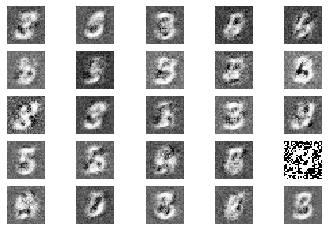

In [22]:
train(epochs=20000,batch_size=32,save_interval=50)

In [14]:
generator.save("E:\GAN\generate.h5")

In [15]:
discriminator.save("E:\GAN\generate.h5")